# **Data Fusion Knowledge Graph Pipeline**

# This notebook contains the complete pipeline for building a data fusion knowledge graph system, from data preprocessing through model training and visualization. Execute the cells sequentially.

## Contents
# 1. [Environment Setup](#1-environment-setup)
# 2. [Data Preprocessing](#2-data-preprocessing)
# 3. [PostgreSQL Database Storage](#3-postgresql-database-storage)
# 4. [Ontology Development](#4-ontology-development)
# 5. [Knowledge Graph Construction](#5-knowledge-graph-construction)
# 6. [BERT Model Training](#6-bert-model-training)
# 7. [Interactive User Interface](#7-interactive-user-interface)

## 1. Environment Setup
# Installing the necessary dependencies.

In [2]:
# Install required packages
!pip install pandas numpy psycopg2-binary sqlalchemy rdflib owlready2 networkx torch transformers gradio matplotlib scikit-learn tqdm
!pip install pyvis term-image
!pip install pyvis.network
!pip install -U "huggingface_hub[cli]"

In [3]:
# Import common libraries that will be used throughout the notebook
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ Environment setup complete")

✅ Environment setup complete


 2. <h3><b>Data Preprocessing & Simulation Code</b></h3>


In [4]:
import pandas as pd
import numpy as np
import uuid
import os

# ===========================
# 🔹 DATA PREPROCESSING 🔹
# ===========================

def preprocess_dataframes():
    print("🔄 Starting data preprocessing...")
    
    file_path = "Updated_fusion_kg.xlsx"
    
    try:
        xls = pd.ExcelFile(file_path)
        print("✅ Available Sheets:", xls.sheet_names)
        
        doi_df = pd.read_excel(xls, sheet_name='DOI')
        fusion_method_df = pd.read_excel(xls, sheet_name='Fusion_Method ')
        data_df = pd.read_excel(xls, sheet_name='Data')
        
        print("\n✅ DOI DataFrame Preview:")
        display(doi_df.head(2))
        
        print("\n✅ Fusion Method DataFrame Preview:")
        display(fusion_method_df.head(2))
        
        print("\n✅ Data DataFrame Preview:")
        display(data_df.head(2))
    
        # Strip column names
        doi_df.columns = doi_df.columns.str.strip()
        fusion_method_df.columns = fusion_method_df.columns.str.strip()
        data_df.columns = data_df.columns.str.strip()
        
        # Drop empty rows
        doi_df.dropna(how="all", inplace=True)
        fusion_method_df.dropna(how="all", inplace=True)
        data_df.dropna(how="all", inplace=True)
        
        # Fix data types for floats to string
        for df in [doi_df, fusion_method_df, data_df]:
            for col in df.select_dtypes(include=['float64']).columns:
                df[col] = df[col].astype(str)
        
        # Fill missing values
        doi_df.fillna("Unknown", inplace=True)
        fusion_method_df.fillna("Unknown", inplace=True)
        data_df.fillna("Unknown", inplace=True)
        
        # Fix publication date
        if "PublicationDate" in doi_df.columns:
            doi_df["PublicationDate"] = pd.to_numeric(doi_df["PublicationDate"], errors='coerce').fillna(0).astype(int)
        
        # Convert to boolean
        if "IsDataFusionPaper" in doi_df.columns:
            doi_df["IsDataFusionPaper"] = doi_df["IsDataFusionPaper"].apply(
                lambda x: True if str(x).lower() == "yes" else False
            )
        
        # Normalize text
        text_columns = [
            "Title", "Author", "Publication Title", "Keywords", "Abstract", 
            "Publisher", "Field of Study", "DataFusionClassificationReason"
        ]
        for col in text_columns:
            if col in doi_df.columns:
                doi_df[col] = doi_df[col].astype(str).str.strip().str.title()
        
        text_columns_fm = ["Method Name", "Description", "U1", "U3", "Output Data"]
        for col in text_columns_fm:
            if col in fusion_method_df.columns:
                fusion_method_df[col] = fusion_method_df[col].astype(str).str.strip().str.title()
        
        text_columns_data = [
            "Data Name", "Collection Method", "U2", "SpatialCoverage", 
            "TemporalCoverage", "Format", "License", "Provenance"
        ]
        for col in text_columns_data:
            if col in data_df.columns:
                data_df[col] = data_df[col].astype(str).str.strip().str.title()
        
        # Fix key columns
        if "DOI" in fusion_method_df.columns:
            fusion_method_df["DOI"] = fusion_method_df["DOI"].astype(str).str.strip()
        
        if "Paper DOI" in data_df.columns:
            data_df["Paper DOI"] = data_df["Paper DOI"].astype(str).str.strip()
        else:
            print("⚠️ Warning: 'Paper DOI' column not found in data table.")
        
        if "Method Key" not in fusion_method_df.columns:
            print("⚠️ Creating 'Method Key' column in fusion_method_df")
            fusion_method_df["Method Key"] = fusion_method_df["Method Name"].apply(
                lambda x: f"method_{str(x).lower().replace(' ', '_')}" if pd.notna(x) else "method_unknown"
            )
        
        if "Method Key" in data_df.columns:
            data_df["Method Key"] = data_df["Method Key"].astype(str).str.strip()
        
        # Test rows
        test_rows = [
            {
                "DOI": str(uuid.uuid4()), 
                "Title": "Test Paper 1", 
                "Author": "Author A",
                "Publication Title": "Test Journal", 
                "PublicationDate": 2023,
                "URL": "https://test.com", 
                "Keywords": "Test, Simulation",
                "Abstract": "This is a test case.", 
                "Publisher": "Test Publisher",
                "Field of Study": "Computer Science", 
                "IsDataFusionPaper": True,
                "DataFusionClassificationReason": "Test case for verification."
            },
            {
                "DOI": str(uuid.uuid4()), 
                "Title": "Test Paper 2", 
                "Author": "Author B",
                "Publication Title": "Test Journal", 
                "PublicationDate": 2022,
                "URL": "https://test.com", 
                "Keywords": "Machine Learning, AI",
                "Abstract": "Another test case.", 
                "Publisher": "Test Publisher",
                "Field of Study": "Artificial Intelligence", 
                "IsDataFusionPaper": False,
                "DataFusionClassificationReason": "Random test data."
            }
        ]
        
        doi_df = pd.concat([doi_df, pd.DataFrame(test_rows)], ignore_index=True)
        
        cleaned_file_path = "Cleaned_Data_Fusion_KG.xlsx"
        with pd.ExcelWriter(cleaned_file_path) as writer:
            doi_df.to_excel(writer, sheet_name="DOI", index=False)
            fusion_method_df.to_excel(writer, sheet_name="Fusion_Method", index=False)
            data_df.to_excel(writer, sheet_name="Data", index=False)
        
        print(f"✅ Data preprocessing complete. Cleaned data saved to {cleaned_file_path}")
        
        print("\n📊 Dataset Statistics:")
        print(f"DOI DataFrame: {len(doi_df)} records")
        print(f"Fusion Method DataFrame: {len(fusion_method_df)} records")
        print(f"Data DataFrame: {len(data_df)} records")
        
        return doi_df, fusion_method_df, data_df
    
    except FileNotFoundError:
        print(f"❌ Error: File '{file_path}' not found. Please update the file path.")
        return None, None, None
    except Exception as e:
        print(f"❌ Error processing data: {str(e)}")
        return None, None, None

# Run preprocessing
doi_df, fusion_method_df, data_df = preprocess_dataframes()

# ===========================
# 🔍 IDENTIFY MISLABELED PAPERS 🔍
# ===========================

if doi_df is not None and data_df is not None:
    # Step 1: Count datasets per paper
    dataset_counts = data_df.groupby("Paper DOI").size().reset_index(name="DatasetCount")

    # Step 2: Merge into DOI dataframe
    doi_with_counts = doi_df.merge(dataset_counts, left_on="DOI", right_on="Paper DOI", how="left")

    # Step 3: Fill missing dataset counts
    doi_with_counts["DatasetCount"] = doi_with_counts["DatasetCount"].fillna(0).astype(int)

    # Step 4: Filter where IsDataFusionPaper is True but DatasetCount == 1
    mislabeled_df = doi_with_counts[
        (doi_with_counts["IsDataFusionPaper"] == True) & 
        (doi_with_counts["DatasetCount"] == 1)
    ]

    # Step 5: Display or inform about misclassified entries
    print("\n❗ Mislabeled Data Fusion Papers (Only 1 associated dataset):")
    if not mislabeled_df.empty:
        display(mislabeled_df[[
            "DOI", "Title", "Author", "Publication Title", 
            "PublicationDate", "DatasetCount", "DataFusionClassificationReason"
        ]])
    else:
        print("✅ No mislabeled data fusion papers found with only one dataset.")


🔄 Starting data preprocessing...
✅ Available Sheets: ['DOI', 'Fusion_Method ', 'Data']

✅ DOI DataFrame Preview:


,DOI,Title,Author,Publication Title,PublicationDate,URL,Keywords,Abstract,Publisher,Field of Study,IsDataFusionPaper,DataFusionClassificationReason
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.1016/j.inffus.2025.102938,Bidomain uncertainty gated recursive network f...,"Junming Hou, Xinyang Liu, Chenxu Wu, Xiaofeng ...",Information Fusion,2025,https://www.sciencedirect.com/science/article/...,Pan-sharpeningImage fusionProgressive fusion f...,Pan-sharpening aims to integrate the complemen...,Information Fusion,NaN,NaN,NaN



✅ Fusion Method DataFrame Preview:


,Method Name,Method Key,DOI,Description,U1,U3,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Output Data
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BUGpan,068a17cf-f726-489b-bdce-d6ac45b25392,10.1016/j.inffus.2025.102938,BUGpan is an pan image sharpening fusion metho...,Addresses uncertainty about applicability to n...,BUGPan offers the highest performance metrics ...,NaN,NaN,NaN,NaN,NaN,HRMS image



✅ Data DataFrame Preview:


,Paper DOI,Data Name,DatasetURL,Method Key,Data Type,Collection Method,U2,SpatialCoverage,TemporalCoverage,Format,License,Provenance
0,10.1016/j.inffus.2025.102938,"Worldview-3 (WV3),",https://earth.esa.int/eogateway/search?categor...,068a17cf-f726-489b-bdce-d6ac45b25392,Satellite Imagery,Colected from worldview -110 camera,Satellite images contain uncertainty pertainin...,Gathers images from entirety of Earth,Data is gathered constanatly every year.,"GIS, JPG, TIF","CC by 4.0 (Assumed based off hints, never dire...",European Space Agency
1,10.1016/j.inffus.2025.102938,GaoFen-2 (GF2),https://www.satimagingcorp.com/satellite-senso...,068a17cf-f726-489b-bdce-d6ac45b25392,Satellite Imagery,Images from the GaoFen-2 Satellite,Satellite images contain uncertainty pertainin...,Gathers images from the entirety of Earth,Actively and constantly gathering data,Data publicly unavailable,NaN,Satellite Imaging Corperation


✅ Data preprocessing complete. Cleaned data saved to Cleaned_Data_Fusion_KG.xlsx

📊 Dataset Statistics:
DOI DataFrame: 103 records
Fusion Method DataFrame: 66 records
Data DataFrame: 120 records

❗ Mislabeled Data Fusion Papers (Only 1 associated dataset):


,DOI,Title,Author,Publication Title,PublicationDate,DatasetCount,DataFusionClassificationReason
70,10.3390/app11188382,Consecutive Independence And Correlation Trans...,"Jia, Chunying; Akhonda, Mohammad Abu Baker Sid...",Applied Sciences-Basel,0,1,States That Multiple Mri Datasets Are Used And...


## 3. PostgreSQL Database Storage: Store the preprocessed data in a PostgreSQL database

In [5]:
from sqlalchemy import create_engine, text
import pandas as pd

# PostgreSQL connection parameters - update these with your database details
DB_NAME = "datafusion"
DB_USER = "postgres"     # Update with your PostgreSQL username
DB_PASSWORD = "Csenior"  # Update with your PostgreSQL password
DB_HOST = "localhost"
DB_PORT = "5432"

# Function to connect to PostgreSQL and create tables (if they don't exist)
def create_postgresql_tables():
    print("🔄 Setting up PostgreSQL database connection...")
    
    try:
        # Create connection string and engine
        conn_string = f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
        engine = create_engine(conn_string)
        
        # Test connection
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
            print("✅ Successfully connected to PostgreSQL")
        
        # Define SQL queries to create tables if they don't exist
        create_table_queries = [
            text("""
            CREATE TABLE IF NOT EXISTS doi_table (
                id SERIAL PRIMARY KEY,
                doi TEXT UNIQUE,
                title TEXT,
                author TEXT,
                publication_title TEXT,
                publication_date INT,
                url TEXT,
                keywords TEXT,
                abstract TEXT,
                publisher TEXT,
                field_of_study TEXT,
                is_data_fusion_paper BOOLEAN,
                data_fusion_classification_reason TEXT
            );
            """),
            text("""
            CREATE TABLE IF NOT EXISTS fusion_method_table (
                id SERIAL PRIMARY KEY,
                method_name TEXT,
                method_key TEXT UNIQUE,
                doi TEXT REFERENCES doi_table(doi),
                description TEXT,
                u1 TEXT,
                u3 TEXT,
                output_data TEXT
            );
            """),
            text("""
            CREATE TABLE IF NOT EXISTS data_table (
                id SERIAL PRIMARY KEY,
                paper_doi TEXT REFERENCES doi_table(doi),
                method_key TEXT REFERENCES fusion_method_table(method_key),
                data_name TEXT,
                dataset_url TEXT,
                data_type TEXT,
                collection_method TEXT,
                u2 TEXT,
                spatial_coverage TEXT,
                temporal_coverage TEXT,
                format TEXT,
                license TEXT,
                provenance TEXT
            );
            """)
        ]
        
        # Execute table creation queries
        with engine.connect() as conn:
            for query in create_table_queries:
                conn.execute(query)
            conn.commit()
            
        print("✅ Database tables created successfully")
        return engine
    
    except Exception as e:
        print(f"❌ Database connection error: {str(e)}")
        return None

# Helper function to prepare DataFrame for SQL insertion
def prepare_dataframe_for_sql(df, target_table):
    if df is None or df.empty:
        print(f"⚠️ Skipping {target_table} - DataFrame is empty or None")
        return None

    # Define column mappings for each table
    column_mappings = {
        'doi_table': {
            'DOI': 'doi',
            'Title': 'title',
            'Author': 'author',
            'Publication Title': 'publication_title',
            'PublicationDate': 'publication_date',
            'URL': 'url',
            'Keywords': 'keywords',
            'Abstract': 'abstract',
            'Publisher': 'publisher',
            'Field of Study': 'field_of_study',
            'IsDataFusionPaper': 'is_data_fusion_paper',
            'DataFusionClassificationReason': 'data_fusion_classification_reason'
        },
        'fusion_method_table': {
            'Method Name': 'method_name',
            'Method Key': 'method_key',
            'DOI': 'doi',
            'Description': 'description',
            'U1': 'u1',
            'U3': 'u3',
            'Output Data': 'output_data'
        },
        'data_table': {
            'Paper DOI': 'paper_doi',
            'Method Key': 'method_key',
            'Data Name': 'data_name',
            'Dataset URL': 'dataset_url',
            'Data Type': 'data_type',
            'Collection Method': 'collection_method',
            'U2': 'u2',
            'SpatialCoverage': 'spatial_coverage',
            'TemporalCoverage': 'temporal_coverage',
            'Format': 'format',
            'License': 'license',
            'Provenance': 'provenance'
        }
    }
    
    # Get the mapping for the specified table
    mapping = column_mappings.get(target_table, {})
    
    # Rename columns based on the mapping
    df_copy = df.rename(columns=mapping).copy()
    
    # Keep only the relevant columns
    valid_columns = list(mapping.values())
    df_copy = df_copy[valid_columns]
    
    return df_copy

# Function to store data in PostgreSQL without dropping tables
def store_data_in_postgresql(doi_df, fusion_method_df, data_df):
    if doi_df is None or fusion_method_df is None or data_df is None:
        print("❌ Cannot store data - one or more DataFrames are None")
        return None

    # Create database tables (if not already created)
    engine = create_postgresql_tables()
    
    if engine:
        try:
            # Prepare and store DOI data
            print("🔄 Preparing DOI data for SQL insertion...")
            doi_sql = prepare_dataframe_for_sql(doi_df, 'doi_table')
            if doi_sql is not None:
                doi_sql.to_sql('doi_table', engine, if_exists='append', index=False)
                print("✅ DOI data stored in PostgreSQL")

            # Prepare and store Fusion Method data
            print("🔄 Preparing Fusion Method data for SQL insertion...")
            fusion_sql = prepare_dataframe_for_sql(fusion_method_df, 'fusion_method_table')
            if fusion_sql is not None:
                fusion_sql.to_sql('fusion_method_table', engine, if_exists='append', index=False)
                print("✅ Fusion Method data stored in PostgreSQL")

            # Prepare and store Data table
            print("🔄 Preparing Dataset data for SQL insertion...")
            data_sql = prepare_dataframe_for_sql(data_df, 'data_table')
            if data_sql is not None:
                data_sql.to_sql('data_table', engine, if_exists='append', index=False)
                print("✅ Dataset data stored in PostgreSQL")

            print("✅ All data successfully stored in PostgreSQL database!")
            return engine

        except Exception as e:
            print(f"❌ Error storing data in PostgreSQL: {str(e)}")
            return None
    else:
        print("❌ Unable to store data - PostgreSQL connection failed")
        return None
 



In [5]:
       # Run the database storage function
engine = store_data_in_postgresql(doi_df, fusion_method_df, data_df)

🔄 Setting up PostgreSQL database connection...
✅ Successfully connected to PostgreSQL
✅ Database tables created successfully
🔄 Preparing DOI data for SQL insertion...
❌ Error storing data in PostgreSQL: (psycopg2.errors.UniqueViolation) duplicate key value violates unique constraint "doi_table_doi_key"
DETAIL:  Key (doi)=(10.1016/j.inffus.2025.102938) already exists.

[SQL: INSERT INTO doi_table (doi, title, author, publication_title, publication_date, url, keywords, abstract, publisher, field_of_study, is_data_fusion_paper, data_fusion_classification_reason) VALUES (%(doi__0)s, %(title__0)s, %(author__0)s, %(publicatio ... 26952 characters truncated ...  %(field_of_study__102)s, %(is_data_fusion_paper__102)s, %(data_fusion_classification_reason__102)s)]
[parameters: {'title__0': 'Bidomain Uncertainty Gated Recursive Network For Pan-Sharpening', 'publication_title__0': 'Information Fusion', 'abstract__0': 'Pan-Sharpening Aims To Integrate The Complementary Information Of Different Moda

## 4. Ontology Development using OWL (Web Ontology Language):

In [6]:
from owlready2 import *

# Define function to create ontology
def create_ontology():
    print("🔄 Creating OWL ontology...")
    
    try:
        # Create or load ontology
        onto = get_ontology("http://example.org/data_fusion.owl")
        
        with onto:
            # Define core ontology classes
            class FusionMethod(Thing):
                """Represents a data fusion method."""
                pass
            
            class Data(Thing):
                """Represents datasets involved in data fusion."""
                pass
            
            class Uncertainty(Thing):
                """Represents different types of uncertainty in datasets."""
                pass
                
            class Paper(Thing):
                """Represents research papers describing fusion methods."""
                pass
            
            # Define relationships (Data Properties)
            class hasUncertainty(DataProperty):
                """Links a dataset to its uncertainty factors."""
                domain = [Data]
                range = [str]
            
            class hasConfidenceLevel(DataProperty):
                """Indicates the confidence level of a fusion method."""
                domain = [FusionMethod]
                range = [float]
            
            class hasDescription(DataProperty):
                """Provides a textual description of the fusion method."""
                domain = [FusionMethod]
                range = [str]
            
            class hasSourceURL(DataProperty):
                """Links a dataset to its source URL for reference."""
                domain = [Data]
                range = [str]
                
            class hasTitle(DataProperty):
                """The title of a research paper."""
                domain = [Paper]
                range = [str]
                
            class hasAuthor(DataProperty):
                """The authors of a research paper."""
                domain = [Paper]
                range = [str]
                
            class hasAbstract(DataProperty):
                """The abstract of a research paper."""
                domain = [Paper]
                range = [str]
            
            # Define object properties (Links between entities)
            class integrates(ObjectProperty):
                """Represents the fusion method integrating with data."""
                domain = [FusionMethod]
                range = [Data]
            
            class isDerivedFrom(ObjectProperty):
                """Links a dataset to another dataset it was derived from."""
                domain = [Data]
                range = [Data]
                
            class describesMethod(ObjectProperty):
                """Links a paper to the fusion methods it describes."""
                domain = [Paper]
                range = [FusionMethod]
                
            class usesData(ObjectProperty):
                """Links a paper to the datasets it uses."""
                domain = [Paper]
                range = [Data]
        
        # Save ontology to a file
        onto_path = "data_fusion.owl"
        onto.save(onto_path)
        print(f"✅ Ontology created and saved to {onto_path}")
        
        return onto
    
    except Exception as e:
        print(f"❌ Error creating ontology: {str(e)}")
        return None

# Create the ontology
onto = create_ontology()

# Populate the ontology with instances from our data
def populate_ontology(onto, doi_df, fusion_method_df, data_df):
    print("🔄 Populating ontology with instances...")
    
    if onto is None:
        print("❌ Cannot populate ontology - ontology is None")
        return None
        
    if doi_df is None or fusion_method_df is None or data_df is None:
        print("❌ Cannot populate ontology - one or more dataframes are None")
        return onto
    
    try:
        with onto:
            # Create Paper instances
            for _, row in doi_df.iterrows():
                # Get DOI or generate a unique ID
                doi = str(row.get('DOI', f"paper_{_}"))
                
                # Create a paper instance
                paper = onto.Paper(doi)
                
                # Add properties
                if 'Title' in row:
                    paper.hasTitle = [str(row['Title'])]
                if 'Author' in row:
                    paper.hasAuthor = [str(row['Author'])]
                if 'Abstract' in row:
                    paper.hasAbstract = [str(row['Abstract'])]
            
            # Create FusionMethod instances
            for _, row in fusion_method_df.iterrows():
                # Get method name or generate a unique ID
                method_name = str(row.get('Method Name', f"method_{_}"))
                method_id = method_name.lower().replace(' ', '_')
                
                # Create a method instance
                method = onto.FusionMethod(method_id)
                
                # Add properties
                if 'Description' in row:
                    method.hasDescription = [str(row['Description'])]
                if 'U1' in row:
                    method.hasUncertainty = [str(row['U1'])]
                    
                # Link to paper if DOI exists
                if 'DOI' in row and row['DOI'] in [p.name for p in onto.Paper.instances()]:
                    paper = onto.search_one(iri=f"*{row['DOI']}")
                    if paper:
                        paper.describesMethod.append(method)
            
            # Create Data instances
            for _, row in data_df.iterrows():
                # Get data name or generate a unique ID
                data_name = str(row.get('Data Name', f"data_{_}"))
                data_id = data_name.lower().replace(' ', '_')
                
                # Create a data instance
                data = onto.Data(data_id)
                
                # Add properties
                if 'U2' in row:
                    data.hasUncertainty = [str(row['U2'])]
                if 'Dataset URL' in row:
                    data.hasSourceURL = [str(row['Dataset URL'])]
                    
                # Link to paper if Paper DOI exists
                if 'Paper DOI' in row and row['Paper DOI'] in [p.name for p in onto.Paper.instances()]:
                    paper = onto.search_one(iri=f"*{row['Paper DOI']}")
                    if paper:
                        paper.usesData.append(data)
                        
                # Link to method if Method Key exists
                if 'Method Key' in row and row['Method Key'] in [m.name for m in onto.FusionMethod.instances()]:
                    method = onto.search_one(iri=f"*{row['Method Key']}")
                    if method:
                        method.integrates.append(data)
        
        # Save the populated ontology
        onto_populated_path = "data_fusion_populated.owl"
        onto.save(onto_populated_path)
        print(f"✅ Populated ontology saved to {onto_populated_path}")
        
        # Print some statistics
        print(f"\n📊 Ontology Statistics:")
        print(f"  Papers: {len(list(onto.Paper.instances()))}")
        print(f"  Fusion Methods: {len(list(onto.FusionMethod.instances()))}")
        print(f"  Datasets: {len(list(onto.Data.instances()))}")
        
        return onto
    
    except Exception as e:
        print(f"❌ Error populating ontology: {str(e)}")
        return onto

# Populate the ontology with our data
onto = populate_ontology(onto, doi_df, fusion_method_df, data_df)

🔄 Creating OWL ontology...
✅ Ontology created and saved to data_fusion.owl
🔄 Populating ontology with instances...
✅ Populated ontology saved to data_fusion_populated.owl

📊 Ontology Statistics:
  Papers: 100
  Fusion Methods: 66
  Datasets: 117


In [7]:
# Creating the RDF Graph
from rdflib import Graph, Namespace, Literal, RDF, URIRef
import matplotlib.pyplot as plt
import networkx as nx

def create_rdf_graph():
    print("🔄 Creating RDF graph...")
    
    try:
        # Create a new RDF graph
        g = Graph()
        FUSION = Namespace("http://example.org/fusion_ontology#")
        
        # Bind namespace
        g.bind("fusion", FUSION)
        
        # Define ontology classes (concepts)
        ontology_classes = ["Paper", "FusionMethod", "Dataset", "Uncertainty"]
        for cls in ontology_classes:
            g.add((FUSION[cls], RDF.type, FUSION.Class))
        
        # Define object properties (relationships)
        ontology_properties = {
            "usesMethod": ("Paper", "FusionMethod"),
            "usesData": ("Paper", "Dataset"),
            "hasUncertainty": ("FusionMethod", "Uncertainty"),
            "hasUncertainty": ("Dataset", "Uncertainty"),
            "isPublishedIn": ("Paper", "Publisher"),
            "integrates": ("FusionMethod", "Dataset"),
            "isDerivedFrom": ("Dataset", "Dataset"),
        }
        
        for prop, (domain, range_) in ontology_properties.items():
            g.add((FUSION[prop], RDF.type, FUSION.ObjectProperty))
            g.add((FUSION[prop], FUSION.domain, FUSION[domain]))
            g.add((FUSION[prop], FUSION.range, FUSION[range_]))
        
        # Add sample instances from our data
        if doi_df is not None:
            # Papers
            for i, (_, row) in enumerate(doi_df.head(5).iterrows()):
                paper_uri = URIRef(FUSION[f"paper_{i}"])
                g.add((paper_uri, RDF.type, FUSION.Paper))
                if 'Title' in row:
                    g.add((paper_uri, FUSION.title, Literal(str(row['Title']))))
                if 'Author' in row:
                    g.add((paper_uri, FUSION.author, Literal(str(row['Author']))))
        
        if fusion_method_df is not None:
            # Fusion Methods
            for i, (_, row) in enumerate(fusion_method_df.head(5).iterrows()):
                method_uri = URIRef(FUSION[f"method_{i}"])
                g.add((method_uri, RDF.type, FUSION.FusionMethod))
                if 'Method Name' in row:
                    g.add((method_uri, FUSION.name, Literal(str(row['Method Name']))))
                if 'Description' in row:
                    g.add((method_uri, FUSION.description, Literal(str(row['Description']))))
        
        if data_df is not None:
            # Datasets
            for i, (_, row) in enumerate(data_df.head(5).iterrows()):
                dataset_uri = URIRef(FUSION[f"dataset_{i}"])
                g.add((dataset_uri, RDF.type, FUSION.Dataset))
                if 'Data Name' in row:
                    g.add((dataset_uri, FUSION.name, Literal(str(row['Data Name']))))
        
        # Add some relationships between instances
        # First paper uses first method
        g.add((URIRef(FUSION["paper_0"]), FUSION.usesMethod, URIRef(FUSION["method_0"])))
        # First paper uses first dataset
        g.add((URIRef(FUSION["paper_0"]), FUSION.usesData, URIRef(FUSION["dataset_0"])))
        # First method integrates first dataset
        g.add((URIRef(FUSION["method_0"]), FUSION.integrates, URIRef(FUSION["dataset_0"])))
        
        # Save the RDF graph
        rdf_path = "fusion_ontology.ttl"
        g.serialize(destination=rdf_path, format="turtle")
        print(f"✅ RDF graph created and saved to {rdf_path}")
        
        # Display some statistics
        print(f"\n📊 RDF Graph Statistics:")
        print(f"  Total triples: {len(g)}")
        print(f"  Classes: {len([s for s, p, o in g if p == RDF.type and o == FUSION.Class])}")
        print(f"  Object Properties: {len([s for s, p, o in g if p == RDF.type and o == FUSION.ObjectProperty])}")
        
        return g
    
    except Exception as e:
        print(f"❌ Error creating RDF graph: {str(e)}")
        return None

# Create the RDF graph
rdf_graph = create_rdf_graph()

🔄 Creating RDF graph...
✅ RDF graph created and saved to fusion_ontology.ttl

📊 RDF Graph Statistics:
  Total triples: 65
  Classes: 4
  Object Properties: 6


## Ontology Visualization

🔄 Generating visualization of ontology structure...
✅ Ontology structure visualization saved to ontology_structure.png


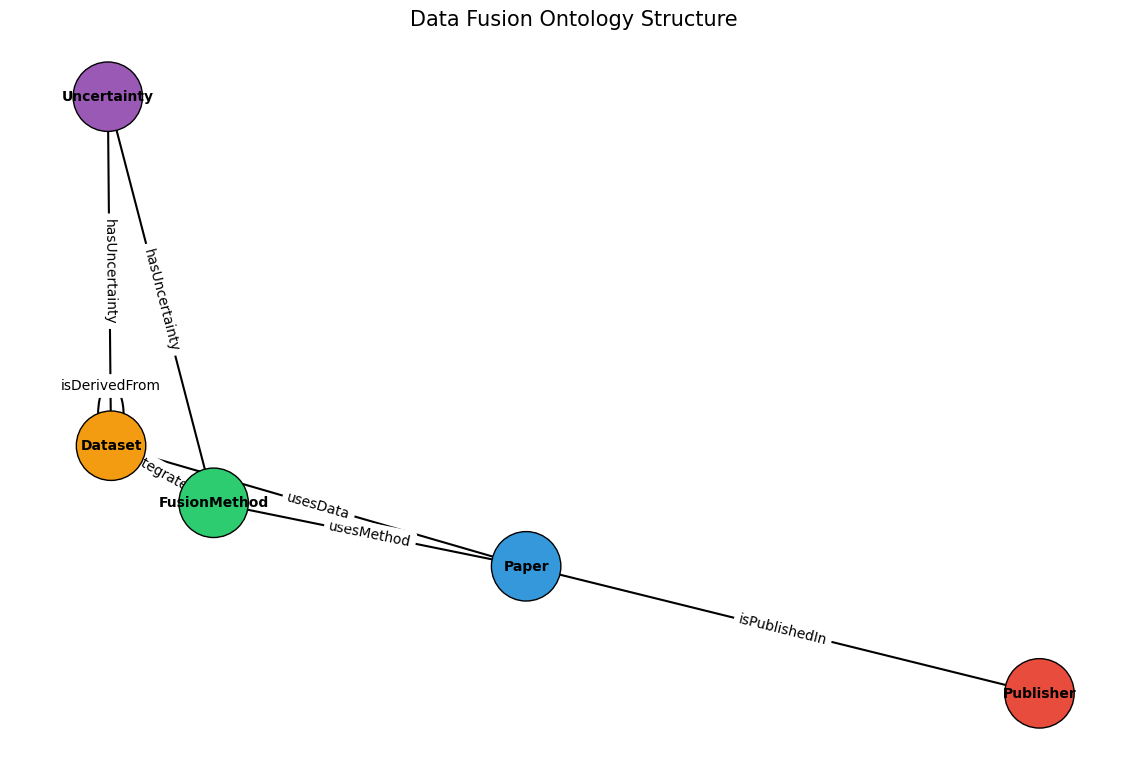

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import webbrowser
from PIL import Image
from term_image.image import AutoImage  # Requires: pip install term-image

def visualize_ontology():
    print("🔄 Generating visualization of ontology structure...")
    # Create the directed graph with color scheme
    G = nx.DiGraph()
    node_colors = {
        "Paper": "#3498db",
        "FusionMethod": "#2ecc71",
        "Dataset": "#f39c12",
        "Uncertainty": "#9b59b6",
        "Publisher": "#e74c3c"
    }
    
    # Add nodes with colors
    for node, color in node_colors.items():
        G.add_node(node, color=color, size=25, shape='box')

    # Add relationships
    relationships = [
        ("Paper", "FusionMethod", "usesMethod"),
        ("Paper", "Dataset", "usesData"),
        ("Paper", "Publisher", "isPublishedIn"),
        ("FusionMethod", "Dataset", "integrates"),
        ("FusionMethod", "Uncertainty", "hasUncertainty"),
        ("Dataset", "Uncertainty", "hasUncertainty"),
        ("Dataset", "Dataset", "isDerivedFrom")
    ]

    for source, target, label in relationships:
        G.add_edge(source, target, label=label, width=2)

    # Generate HTML visualization
    net = Network(height="600px", width="100%", directed=True, notebook=False, cdn_resources="in_line")
    net.from_nx(G)
    
    # Configure physics and appearance
    net.set_options("""
    {
      "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 0,
          "springLength": 200,
          "springConstant": 0.01,
          "nodeDistance": 150,
          "damping": 0.09
        },
        "solver": "hierarchicalRepulsion"
      },
      "edges": {
        "smooth": {
          "type": "cubicBezier",
          "roundness": 0.5
        }
      }
    }
    """)
    
    html_file = "ontology_visualization.html"
    net.save_graph(html_file)
    
    # Generate static image visualization
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = [node_colors[node] for node in G.nodes()]
    plt.title("Data Fusion Ontology Structure", fontsize=15)
    plt.tight_layout()
    
    nx.draw_networkx_nodes(G, pos, node_size=2500, node_color=colors, edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=1.5, arrows=True, arrowsize=20)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    image_file = "ontology_static.png"
    plt.axis('off')
    plt.savefig(image_file, bbox_inches='tight', dpi=150)
    print("✅ Ontology structure visualization saved to ontology_structure.png")
    
    # Display in terminal
    try:
        # Open the image file using PIL and pass the image object
        img = Image.open(image_file)
       # AutoImage(img).draw()  # Pass the image object instead of the filename
    except Exception as e:
        print(f"Terminal image display error: {str(e)}")
        print(f"Static image saved as {image_file}")
    
    # Open HTML in browser
    webbrowser.open(html_file)

if __name__ == "__main__":
    visualize_ontology()

 ## 5.0 Knowledge Graph Construction visualization


🔄 Constructing knowledge graph...
  Adding paper nodes...
  Adding fusion method nodes...
  Adding dataset nodes...
✅ Knowledge graph constructed and saved to data_fusion_graph.graphml

📊 Knowledge Graph Statistics:
  Total nodes: 285
  Total edges: 299
  Papers: 99
  Methods: 66
  Datasets: 120
🔄 Generating visualization of knowledge graph...
✅ Interactive knowledge graph visualization saved to knowledge_graph.html
✅ Knowledge graph visualization saved to knowledge_graph.png


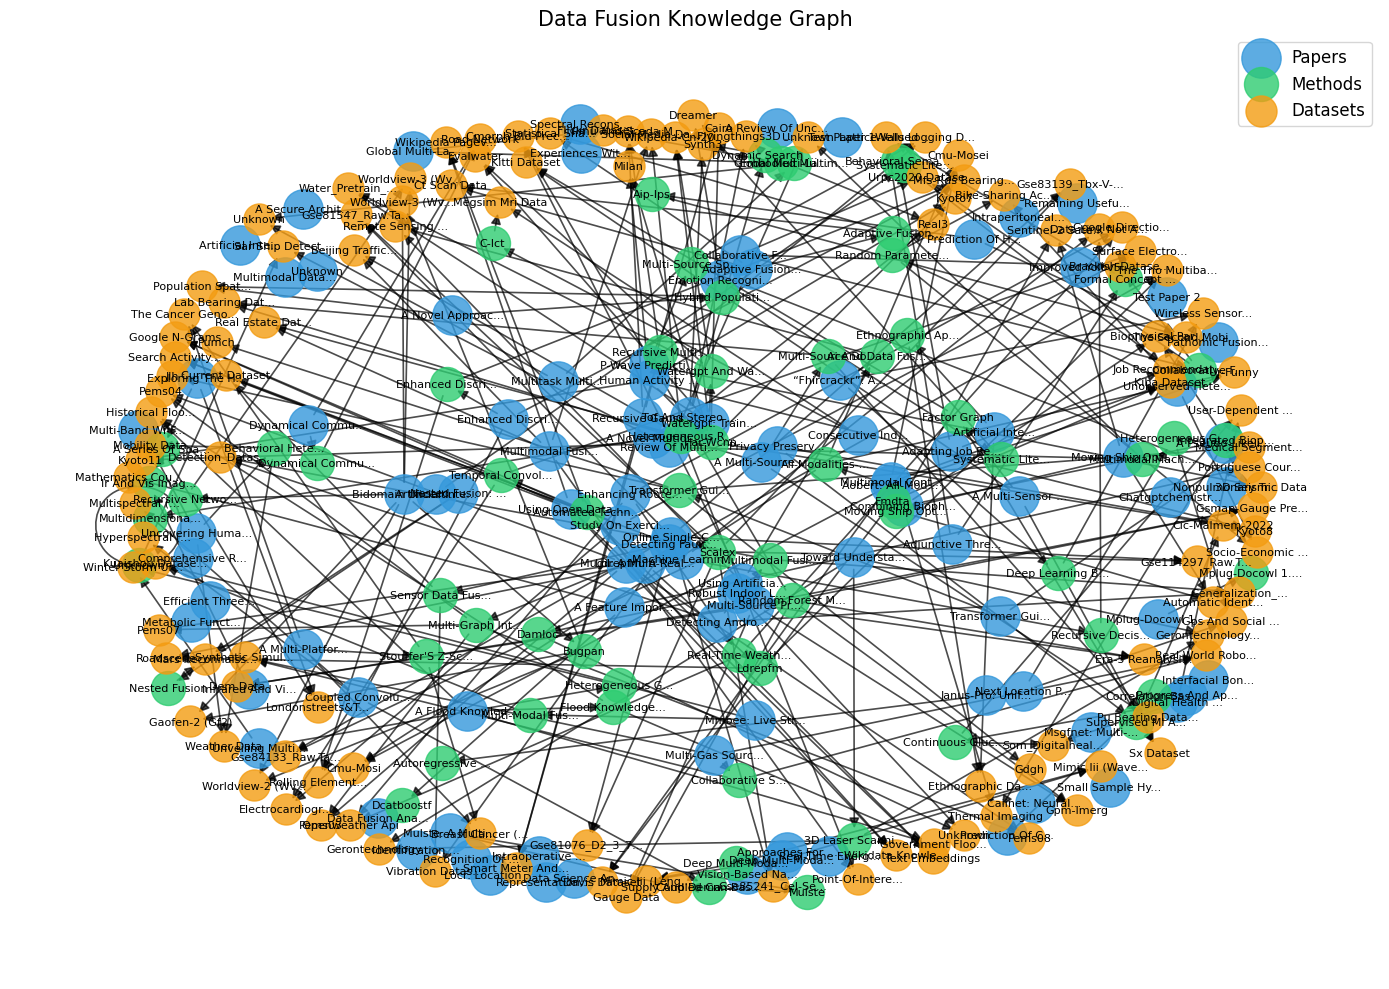

In [8]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

def construct_knowledge_graph(doi_df, fusion_method_df, data_df):
    print("🔄 Constructing knowledge graph...")
    
    if doi_df is None or fusion_method_df is None or data_df is None:
        print("❌ Cannot construct knowledge graph - one or more dataframes are None")
        return None
    
    try:
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add nodes for papers
        print("  Adding paper nodes...")
        for i, (_, row) in enumerate(doi_df.iterrows()):
            paper_id = str(row.get('DOI', f"paper_{i}"))
            title = str(row.get('Title', f"Paper {i}"))
            G.add_node(paper_id, label=title, type="paper")
        
        # Add nodes for fusion methods
        print("  Adding fusion method nodes...")
        for i, (_, row) in enumerate(fusion_method_df.iterrows()):
            method_id = str(row.get('Method Key', f"method_{i}"))
            if pd.isna(method_id) or method_id == "nan" or method_id == "None":
                method_id = f"method_{i}"
            
            method_name = str(row.get('Method Name', f"Method {i}"))
            G.add_node(method_id, label=method_name, type="method")
            
            # Link method to paper if DOI exists
            if 'DOI' in row and not pd.isna(row['DOI']) and row['DOI'] in G.nodes:
                G.add_edge(row['DOI'], method_id, relationship="describes")
        
        # Add nodes for datasets
        print("  Adding dataset nodes...")
        for i, (_, row) in enumerate(data_df.iterrows()):
            data_id = f"data_{i}"
            data_name = str(row.get('Data Name', f"Dataset {i}"))
            G.add_node(data_id, label=data_name, type="dataset")
            
            # Link dataset to paper if Paper DOI exists
            if 'Paper DOI' in row and not pd.isna(row['Paper DOI']) and row['Paper DOI'] in G.nodes:
                G.add_edge(row['Paper DOI'], data_id, relationship="uses")
            
            # Link dataset to method if Method Key exists
            if 'Method Key' in row and not pd.isna(row['Method Key']) and row['Method Key'] in G.nodes:
                G.add_edge(row['Method Key'], data_id, relationship="integrates")
        
        # Save the graph to GraphML format
        graphml_path = "data_fusion_graph.graphml"
        nx.write_graphml(G, graphml_path)
        print(f"✅ Knowledge graph constructed and saved to {graphml_path}")
        
        # Print graph statistics
        print(f"\n📊 Knowledge Graph Statistics:")
        print(f"  Total nodes: {G.number_of_nodes()}")
        print(f"  Total edges: {G.number_of_edges()}")
        paper_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'paper']
        method_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'method']
        dataset_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'dataset']
        print(f"  Papers: {len(paper_nodes)}")
        print(f"  Methods: {len(method_nodes)}")
        print(f"  Datasets: {len(dataset_nodes)}")
        
        return G
    
    except Exception as e:
        print(f"❌ Error constructing knowledge graph: {str(e)}")
        return None

def visualize_knowledge_graph(G):
    print("🔄 Generating visualization of knowledge graph...")
    
    if G is None or G.number_of_nodes() == 0:
        print("❌ Cannot visualize - empty or invalid graph")
        return
    
    try:
        # First, generate the interactive HTML graph
        net = Network(height='800px', width='100%', notebook=True, cdn_resources='remote')

        # Add nodes and edges to the pyvis network
        for node, data in G.nodes(data=True):
            node_type = data.get('type', 'unknown')
            label = data.get('label', node)

            # Color the nodes based on their type
            if node_type == 'paper':
                color = '#3498db'  # Blue
            elif node_type == 'method':
                color = '#2ecc71'  # Green
            elif node_type == 'dataset':
                color = '#f39c12'  # Orange
            else:
                color = '#95a5a6'  # Gray

            net.add_node(node, label=label, title=label, group=node_type, color=color)

        for u, v, data in G.edges(data=True):
            relationship = data.get('relationship', 'related')
            net.add_edge(u, v, title=relationship)
            
        # Add legend
        net.add_node("legend_paper", label="Paper", color="#3498db", x="-300", y="-250", fixed=True, physics=False, size=15, mass=1)
        net.add_node("legend_method", label="Method", color="#2ecc71",  x="-150", y="-250",fixed=True, physics=False, size=15, mass=1)
        net.add_node("legend_dataset", label="Dataset", color="#f39c12",  x="0", y="-250",fixed=True, physics=False, size=15, mass=1)

        # Enable features
        net.show_buttons(filter_=['physics'])
        net.toggle_physics(True)

        # Save the graph as an HTML file
        net.save_graph("knowledge_graph2.html")
        print("✅ Interactive knowledge graph visualization saved to knowledge_graph.html")
        
        # Then, generate the static PNG graph using matplotlib
        plt.figure(figsize=(14, 10))
        pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
        
        # Draw nodes with different colors for each type
        paper_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'paper']
        method_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'method']
        dataset_nodes = [n for n, d in G.nodes(data=True) if d.get('type') == 'dataset']
        
        nx.draw_networkx_nodes(G, pos, nodelist=paper_nodes, 
                               node_color='#3498db', node_size=800, alpha=0.8, label='Papers')
        nx.draw_networkx_nodes(G, pos, nodelist=method_nodes, 
                               node_color='#2ecc71', node_size=600, alpha=0.8, label='Methods')
        nx.draw_networkx_nodes(G, pos, nodelist=dataset_nodes, 
                               node_color='#f39c12', node_size=500, alpha=0.8, label='Datasets')
        
        # Draw edges
        nx.draw_networkx_edges(G, pos, width=1.2, alpha=0.7, arrows=True, arrowsize=15)
        
        # Draw node labels (using 'label' attribute)
        node_labels = {n: d.get('label', n) for n, d in G.nodes(data=True)}
        # Truncate long labels
        node_labels = {n: (l[:15] + '...' if len(l) > 15 else l) for n, l in node_labels.items()}
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
        
        plt.title("Data Fusion Knowledge Graph", fontsize=15)
        plt.legend(fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        
        # Save the figure
        plt.savefig("knowledge_graph.png", bbox_inches='tight', dpi=300)
        print("✅ Knowledge graph visualization saved to knowledge_graph.png")
        
        # Display the plot (optional)
        plt.show()
        
    except Exception as e:
        print(f"❌ Error visualizing knowledge graph: {str(e)}")

# Construct the knowledge graph
knowledge_graph = construct_knowledge_graph(doi_df, fusion_method_df, data_df)

# Visualize the knowledge graph
visualize_knowledge_graph(knowledge_graph)


## 6. BERT Model Training

## a. Training with RoBerta-Base Model

In [26]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# === Data Preparation ===
def prepare_training_data(doi_df):
    print("🔄 Preparing RoBERTa training data...")

    if doi_df is None:
        print("❌ Cannot prepare training data - doi_df is None")
        return None, None

    try:
        is_fusion_col = next((col for col in ["IsDataFusionPaper", "is_data_fusion_paper"] if col in doi_df.columns), None)
        abstract_col = next((col for col in ["Abstract", "abstract"] if col in doi_df.columns), None)

        if is_fusion_col is None or abstract_col is None:
            print("❌ Required columns not found")
            return None, None

        doi_df['label'] = doi_df[is_fusion_col].apply(
            lambda x: 1 if str(x).lower() in ['yes', 'true', '1', 'True'] else 0
        )

        mask = doi_df[abstract_col].notna() & (doi_df[abstract_col] != "")
        filtered_df = doi_df[mask].copy()

        if len(filtered_df) < 10:
            print(f"⚠️ Only {len(filtered_df)} valid examples found — adding synthetic ones...")
            synthetic_examples = [
                {"Abstract": "This paper introduces a novel data fusion method for satellite imagery.", "label": 1},
                {"Abstract": "We propose a new approach to fuse sensor data from multiple sources.", "label": 1},
                {"Abstract": "Data fusion techniques are applied to combine heterogeneous datasets.", "label": 1},
                {"Abstract": "Our methodology integrates data from different modalities to improve accuracy.", "label": 1},
                {"Abstract": "This research focuses on machine learning algorithms for classification tasks.", "label": 0},
                {"Abstract": "We investigate the properties of quantum computing algorithms.", "label": 0},
                {"Abstract": "This paper analyzes the economic impact of trade policies.", "label": 0},
                {"Abstract": "A new method for natural language processing is presented.", "label": 0}
            ]
            synthetic_df = pd.DataFrame(synthetic_examples)
            synthetic_df[abstract_col] = synthetic_df["Abstract"]
            filtered_df = pd.concat([filtered_df, synthetic_df], ignore_index=True)

        texts = filtered_df[abstract_col].astype(str).tolist()
        labels = filtered_df['label'].astype(int).tolist()

        print(f"✅ Prepared {len(texts)} examples: {sum(labels)} positive, {len(labels) - sum(labels)} negative")
        return texts, labels

    except Exception as e:
        print(f"❌ Error preparing training data: {e}")
        return None, None

# === Model Training ===
def train_roberta_model(texts, labels):
    print("🔄 Initializing RoBERTa model for training...")

    model_name = "roberta-base"
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, use_auth_token=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✅ Using device: {device}")

    ros = RandomOverSampler(random_state=42)
    texts = [[t] for t in texts]
    texts, labels = ros.fit_resample(texts, labels)
    texts = [t[0] for t in texts]

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )

    print("📦 Tokenizing...")
    max_length = 128
    train_enc = tokenizer(train_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    val_enc = tokenizer(val_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    train_dataset = TensorDataset(train_enc["input_ids"], train_enc["attention_mask"], torch.tensor(train_labels))
    val_dataset = TensorDataset(val_enc["input_ids"], val_enc["attention_mask"], torch.tensor(val_labels))

    batch_size = 8
    train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model.to(device)
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    epochs = 15
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*epochs)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            batch = tuple(b.to(device) for b in batch)
            outputs = model(input_ids=batch[0], attention_mask=batch[1])
            loss = loss_fn(outputs.logits, batch[2])
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                batch = tuple(b.to(device) for b in batch)
                outputs = model(input_ids=batch[0], attention_mask=batch[1])
                loss = loss_fn(outputs.logits, batch[2])
                val_loss += loss.item()
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_true.extend(batch[2].cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(val_true, val_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(val_true, val_preds, average="binary", zero_division=1)

        print(f"\n📊 Epoch {epoch+1} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss  : {avg_val_loss:.4f}")
        print(f"  Accuracy  : {acc:.4f}")
        print(f"  Precision : {prec:.4f}")
        print(f"  Recall    : {rec:.4f}")
        print(f"  F1 Score  : {f1:.4f}\n")
        print("📋 Classification Report:")
        print(classification_report(val_true, val_preds, target_names=["Not Fusion", "Fusion"], zero_division=1))
        print("\n🔢 Confusion Matrix:")
        print(confusion_matrix(val_true, val_preds))

    return model, tokenizer

# === Final Evaluation ===
def evaluate_model(model, tokenizer, texts, labels, device):
    print("🔍 Final evaluation on validation set...")
    model.eval()

    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels))
    loader = DataLoader(dataset, batch_size=8)

    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch in loader:
            batch = tuple(b.to(device) for b in batch)
            outputs = model(input_ids=batch[0], attention_mask=batch[1])
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(batch[2].cpu().numpy())

    acc = accuracy_score(all_true, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_true, all_preds, average="binary", zero_division=1)

    print(f"✅ Final Accuracy : {acc:.4f}")
    print(f"✅ Final Precision: {prec:.4f}")
    print(f"✅ Final Recall   : {rec:.4f}")
    print(f"✅ Final F1 Score : {f1:.4f}")

# === MAIN EXECUTION ===
try:
    doi_df = pd.read_excel("Cleaned_Data_Fusion_KG.xlsx", sheet_name="DOI")
    doi_df.columns = doi_df.columns.str.strip()
    print("✅ Loaded DOI data:", doi_df.shape)
except Exception as e:
    print("❌ Failed to load DOI data:", e)
    doi_df = None

texts, labels = prepare_training_data(doi_df)

if texts is not None and labels is not None:
    roberta_model, roberta_tokenizer = train_roberta_model(texts, labels)
    if roberta_model:
        _, val_texts, _, val_labels = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        evaluate_model(roberta_model, roberta_tokenizer, val_texts, val_labels, device)
else:
    print("⚠️ Skipping training due to insufficient data.")


✅ Loaded DOI data: (103, 12)
🔄 Preparing RoBERTa training data...
✅ Prepared 103 examples: 31 positive, 72 negative
🔄 Initializing RoBERTa model for training...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Using device: cpu
📦 Tokenizing...


Epoch 1/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 1 Results:
  Train Loss: 0.7014
  Val Loss  : 0.6924
  Accuracy  : 0.4483
  Precision : 0.4286
  Recall    : 0.4286
  F1 Score  : 0.4286

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.47      0.47      0.47        15
      Fusion       0.43      0.43      0.43        14

    accuracy                           0.45        29
   macro avg       0.45      0.45      0.45        29
weighted avg       0.45      0.45      0.45        29


🔢 Confusion Matrix:
[[7 8]
 [8 6]]


Epoch 2/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 2 Results:
  Train Loss: 0.6844
  Val Loss  : 0.6940
  Accuracy  : 0.4828
  Precision : 0.4828
  Recall    : 1.0000
  F1 Score  : 0.6512

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.00      0.00        15
      Fusion       0.48      1.00      0.65        14

    accuracy                           0.48        29
   macro avg       0.74      0.50      0.33        29
weighted avg       0.75      0.48      0.31        29


🔢 Confusion Matrix:
[[ 0 15]
 [ 0 14]]


Epoch 3/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 3 Results:
  Train Loss: 0.6851
  Val Loss  : 0.6895
  Accuracy  : 0.5172
  Precision : 0.5000
  Recall    : 1.0000
  F1 Score  : 0.6667

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.07      0.12        15
      Fusion       0.50      1.00      0.67        14

    accuracy                           0.52        29
   macro avg       0.75      0.53      0.40        29
weighted avg       0.76      0.52      0.39        29


🔢 Confusion Matrix:
[[ 1 14]
 [ 0 14]]


Epoch 4/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 4 Results:
  Train Loss: 0.6850
  Val Loss  : 0.6833
  Accuracy  : 0.6897
  Precision : 0.6087
  Recall    : 1.0000
  F1 Score  : 0.7568

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.40      0.57        15
      Fusion       0.61      1.00      0.76        14

    accuracy                           0.69        29
   macro avg       0.80      0.70      0.66        29
weighted avg       0.81      0.69      0.66        29


🔢 Confusion Matrix:
[[ 6  9]
 [ 0 14]]


Epoch 5/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 5 Results:
  Train Loss: 0.6460
  Val Loss  : 0.6564
  Accuracy  : 0.6552
  Precision : 0.5833
  Recall    : 1.0000
  F1 Score  : 0.7368

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.33      0.50        15
      Fusion       0.58      1.00      0.74        14

    accuracy                           0.66        29
   macro avg       0.79      0.67      0.62        29
weighted avg       0.80      0.66      0.61        29


🔢 Confusion Matrix:
[[ 5 10]
 [ 0 14]]


Epoch 6/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 6 Results:
  Train Loss: 0.5364
  Val Loss  : 0.5613
  Accuracy  : 0.6552
  Precision : 0.8333
  Recall    : 0.3571
  F1 Score  : 0.5000

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.61      0.93      0.74        15
      Fusion       0.83      0.36      0.50        14

    accuracy                           0.66        29
   macro avg       0.72      0.65      0.62        29
weighted avg       0.72      0.66      0.62        29


🔢 Confusion Matrix:
[[14  1]
 [ 9  5]]


Epoch 7/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 7 Results:
  Train Loss: 0.3638
  Val Loss  : 0.4590
  Accuracy  : 0.6552
  Precision : 0.6250
  Recall    : 0.7143
  F1 Score  : 0.6667

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.69      0.60      0.64        15
      Fusion       0.62      0.71      0.67        14

    accuracy                           0.66        29
   macro avg       0.66      0.66      0.65        29
weighted avg       0.66      0.66      0.65        29


🔢 Confusion Matrix:
[[ 9  6]
 [ 4 10]]


Epoch 8/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 8 Results:
  Train Loss: 0.2350
  Val Loss  : 0.3941
  Accuracy  : 0.8276
  Precision : 0.7647
  Recall    : 0.9286
  F1 Score  : 0.8387

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.92      0.73      0.81        15
      Fusion       0.76      0.93      0.84        14

    accuracy                           0.83        29
   macro avg       0.84      0.83      0.83        29
weighted avg       0.84      0.83      0.83        29


🔢 Confusion Matrix:
[[11  4]
 [ 1 13]]


Epoch 9/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 9 Results:
  Train Loss: 0.1789
  Val Loss  : 0.5287
  Accuracy  : 0.7586
  Precision : 0.6667
  Recall    : 1.0000
  F1 Score  : 0.8000

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.53      0.70        15
      Fusion       0.67      1.00      0.80        14

    accuracy                           0.76        29
   macro avg       0.83      0.77      0.75        29
weighted avg       0.84      0.76      0.75        29


🔢 Confusion Matrix:
[[ 8  7]
 [ 0 14]]


Epoch 10/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 10 Results:
  Train Loss: 0.0899
  Val Loss  : 0.5277
  Accuracy  : 0.7931
  Precision : 0.7000
  Recall    : 1.0000
  F1 Score  : 0.8235

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.60      0.75        15
      Fusion       0.70      1.00      0.82        14

    accuracy                           0.79        29
   macro avg       0.85      0.80      0.79        29
weighted avg       0.86      0.79      0.79        29


🔢 Confusion Matrix:
[[ 9  6]
 [ 0 14]]


Epoch 11/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 11 Results:
  Train Loss: 0.0679
  Val Loss  : 1.0458
  Accuracy  : 0.6552
  Precision : 0.5833
  Recall    : 1.0000
  F1 Score  : 0.7368

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.33      0.50        15
      Fusion       0.58      1.00      0.74        14

    accuracy                           0.66        29
   macro avg       0.79      0.67      0.62        29
weighted avg       0.80      0.66      0.61        29


🔢 Confusion Matrix:
[[ 5 10]
 [ 0 14]]


Epoch 12/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 12 Results:
  Train Loss: 0.0725
  Val Loss  : 0.5785
  Accuracy  : 0.7931
  Precision : 0.7000
  Recall    : 1.0000
  F1 Score  : 0.8235

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.60      0.75        15
      Fusion       0.70      1.00      0.82        14

    accuracy                           0.79        29
   macro avg       0.85      0.80      0.79        29
weighted avg       0.86      0.79      0.79        29


🔢 Confusion Matrix:
[[ 9  6]
 [ 0 14]]


Epoch 13/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 13 Results:
  Train Loss: 0.0559
  Val Loss  : 0.8303
  Accuracy  : 0.7586
  Precision : 0.6667
  Recall    : 1.0000
  F1 Score  : 0.8000

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.53      0.70        15
      Fusion       0.67      1.00      0.80        14

    accuracy                           0.76        29
   macro avg       0.83      0.77      0.75        29
weighted avg       0.84      0.76      0.75        29


🔢 Confusion Matrix:
[[ 8  7]
 [ 0 14]]


Epoch 14/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 14 Results:
  Train Loss: 0.0456
  Val Loss  : 0.6749
  Accuracy  : 0.7931
  Precision : 0.7000
  Recall    : 1.0000
  F1 Score  : 0.8235

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.60      0.75        15
      Fusion       0.70      1.00      0.82        14

    accuracy                           0.79        29
   macro avg       0.85      0.80      0.79        29
weighted avg       0.86      0.79      0.79        29


🔢 Confusion Matrix:
[[ 9  6]
 [ 0 14]]


Epoch 15/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 15 Results:
  Train Loss: 0.0442
  Val Loss  : 0.6402
  Accuracy  : 0.7931
  Precision : 0.7000
  Recall    : 1.0000
  F1 Score  : 0.8235

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.60      0.75        15
      Fusion       0.70      1.00      0.82        14

    accuracy                           0.79        29
   macro avg       0.85      0.80      0.79        29
weighted avg       0.86      0.79      0.79        29


🔢 Confusion Matrix:
[[ 9  6]
 [ 0 14]]
🔍 Final evaluation on validation set...
✅ Final Accuracy : 0.7143
✅ Final Precision: 0.5000
✅ Final Recall   : 1.0000
✅ Final F1 Score : 0.6667


# b. Training  with bert-base-uncased Model

In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# === Data Preparation ===
def prepare_training_data(doi_df):
    print("🔄 Preparing BERT training data...")

    if doi_df is None:
        print("❌ Cannot prepare training data - doi_df is None")
        return None, None

    try:
        is_fusion_col = next((col for col in ["IsDataFusionPaper", "is_data_fusion_paper"] if col in doi_df.columns), None)
        abstract_col = next((col for col in ["Abstract", "abstract"] if col in doi_df.columns), None)

        if is_fusion_col is None or abstract_col is None:
            print("❌ Required columns not found")
            return None, None

        doi_df['label'] = doi_df[is_fusion_col].apply(
            lambda x: 1 if str(x).lower() in ['yes', 'true', '1', 'True'] else 0
        )

        mask = doi_df[abstract_col].notna() & (doi_df[abstract_col] != "")
        filtered_df = doi_df[mask].copy()

        if len(filtered_df) < 10:
            print(f"⚠️ Only {len(filtered_df)} valid examples found — adding synthetic ones...")
            synthetic_examples = [
                {"Abstract": "This paper introduces a novel data fusion method for satellite imagery.", "label": 1},
                {"Abstract": "We propose a new approach to fuse sensor data from multiple sources.", "label": 1},
                {"Abstract": "Data fusion techniques are applied to combine heterogeneous datasets.", "label": 1},
                {"Abstract": "Our methodology integrates data from different modalities to improve accuracy.", "label": 1},
                {"Abstract": "This research focuses on machine learning algorithms for classification tasks.", "label": 0},
                {"Abstract": "We investigate the properties of quantum computing algorithms.", "label": 0},
                {"Abstract": "This paper analyzes the economic impact of trade policies.", "label": 0},
                {"Abstract": "A new method for natural language processing is presented.", "label": 0}
            ]
            synthetic_df = pd.DataFrame(synthetic_examples)
            synthetic_df[abstract_col] = synthetic_df["Abstract"]
            filtered_df = pd.concat([filtered_df, synthetic_df], ignore_index=True)

        texts = filtered_df[abstract_col].astype(str).tolist()
        labels = filtered_df['label'].astype(int).tolist()

        print(f"✅ Prepared {len(texts)} examples: {sum(labels)} positive, {len(labels) - sum(labels)} negative")
        return texts, labels

    except Exception as e:
        print(f"❌ Error preparing training data: {e}")
        return None, None

# === Model Training ===
def train_bert_model(texts, labels):
    print("🔄 Initializing BERT model for training...")

    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✅ Using device: {device}")

    ros = RandomOverSampler(random_state=42)
    texts = [[t] for t in texts]
    texts, labels = ros.fit_resample(texts, labels)
    texts = [t[0] for t in texts]

    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.2, stratify=labels, random_state=42
    )

    print("📦 Tokenizing...")
    max_length = 128
    train_enc = tokenizer(train_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    val_enc = tokenizer(val_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    train_dataset = TensorDataset(train_enc["input_ids"], train_enc["attention_mask"], torch.tensor(train_labels))
    val_dataset = TensorDataset(val_enc["input_ids"], val_enc["attention_mask"], torch.tensor(val_labels))

    batch_size = 8
    train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=5e-5)
    epochs = 15

    print(f"🚀 Starting training for {epochs} epochs...\n")

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            batch = tuple(b.to(device) for b in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            torch.cuda.empty_cache()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                batch = tuple(b.to(device) for b in batch)
                inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[2]}
                outputs = model(**inputs)
                val_loss += outputs.loss.item()
                preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
                val_preds.extend(preds)
                val_true.extend(batch[2].cpu().numpy())
                torch.cuda.empty_cache()

        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(val_true, val_preds)
        prec, rec, f1, _ = precision_recall_fscore_support(val_true, val_preds, average="binary", zero_division=1)

        print(f"\n📊 Epoch {epoch+1} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss  : {avg_val_loss:.4f}")
        print(f"  Accuracy  : {acc:.4f}")
        print(f"  Precision : {prec:.4f}")
        print(f"  Recall    : {rec:.4f}")
        print(f"  F1 Score  : {f1:.4f}\n")
        print("📋 Classification Report:")
        print(classification_report(val_true, val_preds, target_names=["Not Fusion", "Fusion"], zero_division=1))
        print("\n🔢 Confusion Matrix:")
        print(confusion_matrix(val_true, val_preds))

    return model, tokenizer

# === Final Evaluation ===
def evaluate_model(model, tokenizer, texts, labels, device):
    print("🔍 Final evaluation on validation set...")
    model.eval()

    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels))
    loader = DataLoader(dataset, batch_size=8)

    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch in loader:
            batch = tuple(b.to(device) for b in batch)
            outputs = model(input_ids=batch[0], attention_mask=batch[1])
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(batch[2].cpu().numpy())

    acc = accuracy_score(all_true, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_true, all_preds, average="binary", zero_division=1)

    print(f"✅ Final Accuracy : {acc:.4f}")
    print(f"✅ Final Precision: {prec:.4f}")
    print(f"✅ Final Recall   : {rec:.4f}")
    print(f"✅ Final F1 Score : {f1:.4f}")

    print("\n📋 Classification Report:")
    print(classification_report(all_true, all_preds, target_names=["Not Fusion", "Fusion"], zero_division=1))
    print("\n🔢 Confusion Matrix:")
    print(confusion_matrix(all_true, all_preds))

# === MAIN EXECUTION ===
try:
    doi_df = pd.read_excel("Cleaned_Data_Fusion_KG.xlsx", sheet_name="DOI")
    doi_df.columns = doi_df.columns.str.strip()
    print("✅ Loaded DOI data:", doi_df.shape)
except Exception as e:
    print("❌ Failed to load DOI data:", e)
    doi_df = None

texts, labels = prepare_training_data(doi_df)

if texts is not None and labels is not None:
    bert_model, bert_tokenizer = train_bert_model(texts, labels)
    if bert_model:
        _, val_texts, _, val_labels = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        evaluate_model(bert_model, bert_tokenizer, val_texts, val_labels, device)
else:
    print("⚠️ Skipping training due to insufficient data.")


✅ Loaded DOI data: (103, 12)
🔄 Preparing BERT training data...
✅ Prepared 103 examples: 31 positive, 72 negative
🔄 Initializing BERT model for training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Using device: cpu
📦 Tokenizing...
🚀 Starting training for 15 epochs...



Epoch 1/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 1 Results:
  Train Loss: 0.7190
  Val Loss  : 0.6869
  Accuracy  : 0.5517
  Precision : 1.0000
  Recall    : 0.0714
  F1 Score  : 0.1333

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.54      1.00      0.70        15
      Fusion       1.00      0.07      0.13        14

    accuracy                           0.55        29
   macro avg       0.77      0.54      0.42        29
weighted avg       0.76      0.55      0.43        29


🔢 Confusion Matrix:
[[15  0]
 [13  1]]


Epoch 2/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 2 Results:
  Train Loss: 0.7075
  Val Loss  : 0.6830
  Accuracy  : 0.4828
  Precision : 0.4828
  Recall    : 1.0000
  F1 Score  : 0.6512

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.00      0.00        15
      Fusion       0.48      1.00      0.65        14

    accuracy                           0.48        29
   macro avg       0.74      0.50      0.33        29
weighted avg       0.75      0.48      0.31        29


🔢 Confusion Matrix:
[[ 0 15]
 [ 0 14]]


Epoch 3/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 3 Results:
  Train Loss: 0.6437
  Val Loss  : 0.5450
  Accuracy  : 0.8621
  Precision : 1.0000
  Recall    : 0.7143
  F1 Score  : 0.8333

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.79      1.00      0.88        15
      Fusion       1.00      0.71      0.83        14

    accuracy                           0.86        29
   macro avg       0.89      0.86      0.86        29
weighted avg       0.89      0.86      0.86        29


🔢 Confusion Matrix:
[[15  0]
 [ 4 10]]


Epoch 4/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 4 Results:
  Train Loss: 0.4856
  Val Loss  : 0.8596
  Accuracy  : 0.5862
  Precision : 1.0000
  Recall    : 0.1429
  F1 Score  : 0.2500

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.56      1.00      0.71        15
      Fusion       1.00      0.14      0.25        14

    accuracy                           0.59        29
   macro avg       0.78      0.57      0.48        29
weighted avg       0.77      0.59      0.49        29


🔢 Confusion Matrix:
[[15  0]
 [12  2]]


Epoch 5/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 5 Results:
  Train Loss: 0.4624
  Val Loss  : 0.3337
  Accuracy  : 0.8966
  Precision : 1.0000
  Recall    : 0.7857
  F1 Score  : 0.8800

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.83      1.00      0.91        15
      Fusion       1.00      0.79      0.88        14

    accuracy                           0.90        29
   macro avg       0.92      0.89      0.89        29
weighted avg       0.91      0.90      0.90        29


🔢 Confusion Matrix:
[[15  0]
 [ 3 11]]


Epoch 6/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 6 Results:
  Train Loss: 0.2573
  Val Loss  : 0.3643
  Accuracy  : 0.8276
  Precision : 0.8000
  Recall    : 0.8571
  F1 Score  : 0.8276

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.86      0.80      0.83        15
      Fusion       0.80      0.86      0.83        14

    accuracy                           0.83        29
   macro avg       0.83      0.83      0.83        29
weighted avg       0.83      0.83      0.83        29


🔢 Confusion Matrix:
[[12  3]
 [ 2 12]]


Epoch 7/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 7 Results:
  Train Loss: 0.1670
  Val Loss  : 0.4017
  Accuracy  : 0.8621
  Precision : 1.0000
  Recall    : 0.7143
  F1 Score  : 0.8333

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.79      1.00      0.88        15
      Fusion       1.00      0.71      0.83        14

    accuracy                           0.86        29
   macro avg       0.89      0.86      0.86        29
weighted avg       0.89      0.86      0.86        29


🔢 Confusion Matrix:
[[15  0]
 [ 4 10]]


Epoch 8/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 8 Results:
  Train Loss: 0.1427
  Val Loss  : 1.2261
  Accuracy  : 0.6897
  Precision : 0.6190
  Recall    : 0.9286
  F1 Score  : 0.7429

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.88      0.47      0.61        15
      Fusion       0.62      0.93      0.74        14

    accuracy                           0.69        29
   macro avg       0.75      0.70      0.68        29
weighted avg       0.75      0.69      0.67        29


🔢 Confusion Matrix:
[[ 7  8]
 [ 1 13]]


Epoch 9/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 9 Results:
  Train Loss: 0.0842
  Val Loss  : 0.1629
  Accuracy  : 0.9655
  Precision : 1.0000
  Recall    : 0.9286
  F1 Score  : 0.9630

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.94      1.00      0.97        15
      Fusion       1.00      0.93      0.96        14

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.97        29
weighted avg       0.97      0.97      0.97        29


🔢 Confusion Matrix:
[[15  0]
 [ 1 13]]


Epoch 10/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 10 Results:
  Train Loss: 0.0520
  Val Loss  : 0.6838
  Accuracy  : 0.8276
  Precision : 0.7647
  Recall    : 0.9286
  F1 Score  : 0.8387

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.92      0.73      0.81        15
      Fusion       0.76      0.93      0.84        14

    accuracy                           0.83        29
   macro avg       0.84      0.83      0.83        29
weighted avg       0.84      0.83      0.83        29


🔢 Confusion Matrix:
[[11  4]
 [ 1 13]]


Epoch 11/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 11 Results:
  Train Loss: 0.0483
  Val Loss  : 0.5665
  Accuracy  : 0.8621
  Precision : 0.8125
  Recall    : 0.9286
  F1 Score  : 0.8667

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.92      0.80      0.86        15
      Fusion       0.81      0.93      0.87        14

    accuracy                           0.86        29
   macro avg       0.87      0.86      0.86        29
weighted avg       0.87      0.86      0.86        29


🔢 Confusion Matrix:
[[12  3]
 [ 1 13]]


Epoch 12/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 12 Results:
  Train Loss: 0.0498
  Val Loss  : 0.2926
  Accuracy  : 0.9310
  Precision : 0.9286
  Recall    : 0.9286
  F1 Score  : 0.9286

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.93      0.93      0.93        15
      Fusion       0.93      0.93      0.93        14

    accuracy                           0.93        29
   macro avg       0.93      0.93      0.93        29
weighted avg       0.93      0.93      0.93        29


🔢 Confusion Matrix:
[[14  1]
 [ 1 13]]


Epoch 13/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 13 Results:
  Train Loss: 0.0463
  Val Loss  : 0.9893
  Accuracy  : 0.7931
  Precision : 0.7222
  Recall    : 0.9286
  F1 Score  : 0.8125

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.91      0.67      0.77        15
      Fusion       0.72      0.93      0.81        14

    accuracy                           0.79        29
   macro avg       0.82      0.80      0.79        29
weighted avg       0.82      0.79      0.79        29


🔢 Confusion Matrix:
[[10  5]
 [ 1 13]]


Epoch 14/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 14 Results:
  Train Loss: 0.0977
  Val Loss  : 0.1898
  Accuracy  : 0.9655
  Precision : 1.0000
  Recall    : 0.9286
  F1 Score  : 0.9630

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.94      1.00      0.97        15
      Fusion       1.00      0.93      0.96        14

    accuracy                           0.97        29
   macro avg       0.97      0.96      0.97        29
weighted avg       0.97      0.97      0.97        29


🔢 Confusion Matrix:
[[15  0]
 [ 1 13]]


Epoch 15/15 [Training]:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/15 [Validation]:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Epoch 15 Results:
  Train Loss: 0.1191
  Val Loss  : 0.7384
  Accuracy  : 0.8276
  Precision : 0.7647
  Recall    : 0.9286
  F1 Score  : 0.8387

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       0.92      0.73      0.81        15
      Fusion       0.76      0.93      0.84        14

    accuracy                           0.83        29
   macro avg       0.84      0.83      0.83        29
weighted avg       0.84      0.83      0.83        29


🔢 Confusion Matrix:
[[11  4]
 [ 1 13]]
🔍 Final evaluation on validation set...
✅ Final Accuracy : 0.8095
✅ Final Precision: 0.6000
✅ Final Recall   : 1.0000
✅ Final F1 Score : 0.7500

📋 Classification Report:
              precision    recall  f1-score   support

  Not Fusion       1.00      0.73      0.85        15
      Fusion       0.60      1.00      0.75         6

    accuracy                           0.81        21
   macro avg       0.80      0.87      0.80        21
weighted avg      

## 7.0 Interactive User Interface

In [27]:
import gradio as gr
import networkx as nx
from pyvis.network import Network
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, BertForSequenceClassification
from IPython.display import display, HTML
import time

# Define color theme and styling
PRIMARY_COLOR = "#5D5CDE"  # Nice purple color
SECONDARY_COLOR = "#4A49B2"  # Darker purple for hover states
LIGHT_BG = "#FFFFFF"
DARK_BG = "#181818"
SUCCESS_COLOR = "#28a745"
WARNING_COLOR = "#ffc107"
ERROR_COLOR = "#dc3545"
CLASSIFICATION_COLOR = "#17a2b8"

# Custom CSS for styling the interface
custom_css = """
/* Base styles */
body {
    font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif;
    line-height: 1.6;
}

/* Header */
h1, h2, h3 {
    font-weight: 700;
    margin-bottom: 1rem;
}

/* Color Theme */
.primary-bg {
    background-color: """ + PRIMARY_COLOR + """;
}
.primary-text {
    color: """ + PRIMARY_COLOR + """;
}

/* Cards */
.card-container {
    display: grid;
    grid-template-columns: repeat(auto-fill, minmax(300px, 1fr));
    gap: 16px;
    margin-top: 20px;
}

.card {
    border-radius: 8px;
    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    padding: 16px;
    margin-bottom: 16px;
    transition: transform 0.2s ease, box-shadow 0.2s ease;
    background-color: white;
    overflow: hidden;
}

.card:hover {
    transform: translateY(-5px);
    box-shadow: 0 6px 12px rgba(0, 0, 0, 0.15);
}

.card h4 {
    font-size: 18px;
    margin-top: 0;
    margin-bottom: 12px;
    color: #333;
}

.card p {
    margin: 8px 0;
    font-size: 14px;
}

.card strong {
    font-weight: 600;
}

/* Paper card */
.paper-card {
    border-left: 4px solid #3498db;
}

/* Method card */
.method-card {
    border-left: 4px solid #2ecc71;
}

/* Dataset card */
.dataset-card {
    border-left: 4px solid #f39c12;
}

/* Search result tags */
.tag {
    display: inline-block;
    padding: 3px 8px;
    margin: 2px;
    border-radius: 12px;
    font-size: 12px;
    background-color: #f0f0f0;
}

/* Graph container */
.graph-container {
    height: 600px;
    border-radius: 8px;
    overflow: hidden;
    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    margin-top: 16px;
    margin-bottom: 16px;
}

/* Loading animation */
.loading {
    display: flex;
    align-items: center;
    justify-content: center;
    height: 300px;
}

.spinner {
    width: 40px;
    height: 40px;
    border: 4px solid rgba(0, 0, 0, 0.1);
    border-left-color: """ + PRIMARY_COLOR + """;
    border-radius: 50%;
    animation: spin 1s linear infinite;
}

@keyframes spin {
    0% { transform: rotate(0deg); }
    100% { transform: rotate(360deg); }
}

/* Tabs styling */
.tab-nav button.selected {
    background-color: """ + PRIMARY_COLOR + """ !important;
    color: white !important;
}

/* Responsive design */
@media (max-width: 768px) {
    .card-container {
        grid-template-columns: 1fr;
    }
}

/* Dark mode support */
@media (prefers-color-scheme: dark) {
    body {
        background-color: #1a1a1a;
        color: #f0f0f0;
    }
    
    .card {
        background-color: #2a2a2a;
        color: #f0f0f0;
    }
    
    .card h4 {
        color: #f0f0f0;
    }
    
    .tag {
        background-color: #333;
        color: #f0f0f0;
    }
}

/* Button styling */
button.primary {
    background-color: """ + PRIMARY_COLOR + """;
    color: white;
    border: none;
    padding: 10px 16px;
    border-radius: 4px;
    cursor: pointer;
    font-weight: 500;
    transition: background-color 0.3s ease;
}

button.primary:hover {
    background-color: """ + SECONDARY_COLOR + """;
}

/* Keyword tags */
.keyword-tag {
    display: inline-block;
    padding: 3px 8px;
    margin: 2px;
    border-radius: 12px;
    font-size: 12px;
    background-color: #f0f0f0;
    color: #333;
}

/* Classification badge */
.classification-badge {
    display: inline-block;
    padding: 4px 10px;
    border-radius: 16px;
    font-weight: 600;
    font-size: 13px;
}

.positive-classification {
    background-color: """ + CLASSIFICATION_COLOR  + """;
    color: white;
}

.negative-classification {
    background-color: #f8f9fa;
    color: #495057;
}

/* Legend */
.legend {
    display: flex;
    gap: 20px;
    margin-bottom: 10px;
    flex-wrap: wrap;
}

.legend-item {
    display: flex;
    align-items: center;
    font-size: 14px;
}

.legend-color {
    width: 16px;
    height: 16px;
    border-radius: 50%;
    margin-right: 6px;
}

/* Info boxes */
.info-box {
    padding: 15px;
    border-radius: 8px;
    margin-bottom: 16px;
    background-color: #f8f9fa;
    border-left: 4px solid #6c757d;
}

.info-box.success {
    background-color: #d4edda;
    border-left-color: #28a745;
    color: #155724;
}

.info-box.warning {
    background-color: #fff3cd;
    border-left-color: #ffc107;
    color: #856404;
}

.info-box.error {
    background-color: #f8d7da;
    border-left-color: #dc3545;
    color: #721c24;
}

/* Search statistics */
.search-stats {
    font-size: 14px;
    margin-bottom: 10px;
    color: #6c757d;
}

/* Graph responsiveness */
iframe {
    width: 100%;
    border: none;
    border-radius: 8px;
}

/* Read more button styling */
.read-more-btn {
    background: none;
    border: none;
    color: """ + PRIMARY_COLOR + """;
    text-decoration: underline;
    cursor: pointer;
    padding: 0;
    font: inherit;
    margin-left: 4px;
}

.read-more-btn:hover {
    color: """ + SECONDARY_COLOR + """;
}

.abstract-full {
    display: none;
}
"""

# Load data
def load_data():
    try:
        doi_df = pd.read_excel("Cleaned_Data_Fusion_KG.xlsx", sheet_name="DOI")
        fusion_df = pd.read_excel("Cleaned_Data_Fusion_KG.xlsx", sheet_name="Fusion_Method")
        data_df = pd.read_excel("Cleaned_Data_Fusion_KG.xlsx", sheet_name="Data")
        print("✅ Data loaded successfully")
        return doi_df, fusion_df, data_df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        # Create sample data if loading fails
        doi_data = {
            "DOI": ["10.1016/j.inffus.2023.102938", "10.1016/j.inffus.2023.101769", "10.1016/j.optcom.2022.128392"],
            "Title": [
                "Bidomain uncertainty gated recursive network for pan-sharpening",
                "Multimodal video fusion based on spatial-temporal attention",
                "Self-calibration-based data fusion algorithm for drift reduction"
            ],
            "Author": [
                "Junming Hou et al.",
                "Wei Li et al.",
                "Wang Qi et al."
            ],
            "Publication Title": ["Information Fusion", "Information Fusion", "Optics Communications"],
            "PublicationDate": [2023, 2023, 2022],
            "Keywords": [
                "Pan-sharpening, Image fusion",
                "Video fusion, Multimodal",
                "Fiber-optic gyroscope, Self-calibration"
            ],
            "Abstract": [
                "Pan-sharpening aims to integrate the complementary information of different modalities of satellite images, e.g., texture-rich PAN images and multi-spectral (MS) images, to produce more informative fusion images for various practical tasks. Currently, most deep learning based pan-sharpening techniques primarily concentrate on developing various elaborate architectures to enhance their representation capabilities. Despite significant advancements, these heuristic and intricate network designs result in models that lack interpretability and exhibit poor generalization ability in real-world scenarios. To alleviate these issues, we propose a simple yet effective spatial-frequency (bidomain) uncertainty gated progressive fusion framework for pan-sharpening, termed BUGPan.",
                "A novel approach for multimodal video fusion using attention mechanisms. This extended abstract contains additional information about the video fusion approach and spatial-temporal attention mechanisms that improve fusion quality and address real-time processing challenges in multimedia applications, particularly for applications with dynamic content.",
                "A self-calibration algorithm for drift reduction in fiber-optic gyroscopes. The full abstract contains methodological details about how the self-calibration approach works and how it helps reduce drift in navigation systems, addressing key challenges in sensor fusion for autonomous systems and precision navigation devices."
            ],
            "IsDataFusionPaper": [True, True, True]
        }

        fusion_data = {
            "Method Name": ["BUGPan", "MMVF-SPA", "SC-DFA"],
            "DOI": ["10.1016/j.inffus.2023.102938", "10.1016/j.inffus.2023.101769", "10.1016/j.optcom.2022.128392"],
            "Description": [
                "A progressive fusion framework addressing spatial-frequency uncertainty",
                "A fusion approach for video data using spatial-temporal attention",
                "A self-calibration algorithm for sensor data fusion"
            ],
            "U1": [
                "Spatial-frequency uncertainty",
                "Temporal alignment issues",
                "Calibration accuracy limitations"
            ],
            "U3": [
                "Variable performance across image types",
                "Variable performance in different lighting",
                "Long-term drift effects"
            ]
        }

        data_data = {
            "Data Name": ["WorldView-3", "FLIR Thermal Dataset", "FOG Sensor Data"],
            "Paper DOI": ["10.1016/j.inffus.2023.102938", "10.1016/j.inffus.2023.101769", "10.1016/j.optcom.2022.128392"],
            "Data Type": ["Satellite Imagery", "Thermal Video", "Sensor Data"],
            "Collection Method": ["Satellite sensors", "Thermal cameras", "Fiber-optic gyroscopes"],
            "U2": [
                "Resolution-based uncertainty",
                "Temperature calibration variance",
                "Drift due to temperature variations"
            ]
        }

        doi_df = pd.DataFrame(doi_data)
        fusion_df = pd.DataFrame(fusion_data)
        data_df = pd.DataFrame(data_data)
        print("ℹ️ Using sample data")
        return doi_df, fusion_df, data_df

# Load BERT model
def load_bert_model():
    try:
        model_path = "bert_fusion_classifier.pt"
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
            print("✅ BERT model loaded successfully")
        else:
            print("⚠️ BERT model not found, using untrained model")
        return tokenizer, model
    except Exception as e:
        print(f"❌ Error loading BERT model: {e}")
        return None, None

# Load data and model
doi_df, fusion_df, data_df = load_data()
tokenizer, model = load_bert_model()

# Create interactive graph - Modified to use iframe embedding like the first code
def create_interactive_graph(doi_df, fusion_df, data_df, search_term=None):
    try:
        # Create a directed graph
        G = nx.DiGraph()

        # Add nodes for papers (filter by search term if provided)
        for i, row in doi_df.iterrows():
            if search_term is not None:
                title = str(row.get('Title', ''))
                abstract = str(row.get('Abstract', ''))
                keywords = str(row.get('Keywords', ''))

                if search_term.lower() not in title.lower() and search_term.lower() not in abstract.lower() and search_term.lower() not in keywords.lower():
                    continue

            paper_id = str(row.get('DOI', f"paper_{i}"))
            title = str(row.get('Title', f"Paper {i}"))
            G.add_node(paper_id, label=title, type="paper", group=1)

        # Add nodes for fusion methods
        for i, row in fusion_df.iterrows():
            if search_term is not None:
                method_name = str(row.get('Method Name', ''))
                description = str(row.get('Description', ''))

                if search_term.lower() not in method_name.lower() and search_term.lower() not in description.lower():
                    continue

            method_id = f"method_{i}"
            method_name = str(row.get('Method Name', f"Method {i}"))
            G.add_node(method_id, label=method_name, type="method", group=2)

            if 'DOI' in row and pd.notna(row['DOI']) and row['DOI'] in G.nodes:
                G.add_edge(row['DOI'], method_id, title="describes")

        # Add nodes for datasets
        for i, row in data_df.iterrows():
            if search_term is not None:
                data_name = str(row.get('Data Name', ''))
                data_type = str(row.get('Data Type', ''))

                if search_term.lower() not in data_name.lower() and search_term.lower() not in data_type.lower():
                    continue

            data_id = f"data_{i}"
            data_name = str(row.get('Data Name', f"Dataset {i}"))
            G.add_node(data_id, label=data_name, type="dataset", group=3)

            if 'Paper DOI' in row and pd.notna(row['Paper DOI']) and row['Paper DOI'] in G.nodes:
                G.add_edge(row['Paper DOI'], data_id, title="uses")

        # Create a pyvis network
        net = Network(height="600px", width="100%", notebook=False, directed=True, bgcolor="#ffffff", font_color="#333333")

        # Add nodes from the NetworkX graph with improved styling
        for node, attrs in G.nodes(data=True):
            if attrs.get('group') == 1:  # Paper
                color = "#3498db"
                title = f"Paper: {attrs.get('label', '')}"
                size = 25
            elif attrs.get('group') == 2:  # Method
                color = "#2ecc71" 
                title = f"Method: {attrs.get('label', '')}"
                size = 20
            else:  # Dataset
                color = "#f39c12"
                title = f"Dataset: {attrs.get('label', '')}"
                size = 18

            net.add_node(
                node, 
                label=attrs.get('label', node), 
                color=color, 
                title=title,
                size=size,
                shape="dot" if attrs.get('group') == 1 else "dot"
            )

        # Add edges with improved styling
        for source, target, attrs in G.edges(data=True):
            relation = attrs.get('title', 'related to')
            edge_color = "#777777"
            edge_width = 1.5
            
            # Different colors for different relationship types
            if relation == "describes":
                edge_color = "#2980b9"  # Blue for "describes" relationship
                edge_width = 2
            elif relation == "uses":
                edge_color = "#27ae60"  # Green for "uses" relationship
                edge_width = 2
                
            net.add_edge(
                source, 
                target, 
                title=relation, 
                color=edge_color, 
                width=edge_width,
                arrows={"to": {"enabled": True, "scaleFactor": 0.5}}
            )

        # Set physics options for better visualization
        net.set_options("""
        {
          "physics": {
            "forceAtlas2Based": {
              "gravitationalConstant": -50,
              "centralGravity": 0.01,
              "springLength": 100,
              "springConstant": 0.08
            },
            "maxVelocity": 50,
            "solver": "forceAtlas2Based",
            "timestep": 0.35,
            "stabilization": {
              "enabled": true,
              "iterations": 1000
            }
          },
          "interaction": {
            "navigationButtons": true,
            "keyboard": true,
            "hover": true
          },
          "edges": {
            "smooth": {
              "type": "continuous",
              "forceDirection": "none",
              "roundness": 0.5
            }
          },
          "nodes": {
            "font": {
              "size": 14,
              "face": "Arial"
            },
            "borderWidth": 2,
            "shadow": true
          }
        }
        """)

        # Generate the HTML file
        html_file = "graph_temp.html"
        net.save_graph(html_file)

        # Add legend to the HTML file
        with open(html_file, 'r', encoding='utf-8') as f:
            html_raw = f.read()

        # Create iframe HTML similar to the first code
        iframe_html = f"""
        <div class="graph-container">
            <iframe srcdoc="{html_raw.replace('"', '&quot;')}" 
                    width="100%" height="600px" style="border:none;"></iframe>
        </div>
        """

        return iframe_html, G.number_of_nodes(), G.number_of_edges()

    except Exception as e:
        print(f"❌ Error creating interactive graph: {e}")
        return f"<div class='info-box error'>Error creating graph: {e}</div>", 0, 0

# Function to classify text using BERT
def classify_text(text, tokenizer, model):
    if not text or tokenizer is None or model is None:
        return "N/A", 0.0

    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        confidence = probs[0][prediction].item()

        label = "Data Fusion Paper" if prediction == 1 else "Not a Data Fusion Paper"
        return label, confidence

    except Exception as e:
        print(f"Error classifying text: {e}")
        return "Error", 0.0

# Function to search for papers, methods, and datasets
def search_knowledge_graph(search_term, search_type):
    if not search_term:
        return (
            "<div class='info-box'>Please enter a search term to begin exploring the knowledge graph.</div>",
            "<div class='info-box'>The knowledge graph visualization will appear here after your search.</div>"
        )

    search_term = search_term.lower()
    results = []
    
    # Show loading indicator
    loading_html = """
    <div class='loading'>
        <div class='spinner'></div>
        <p style='margin-left: 10px;'>Searching the knowledge graph...</p>
    </div>
    """
    
    # Simulate a short delay to show loading indicator (this would be removed in production)
    time.sleep(0.5)

    try:
        # Search in papers
        if search_type in ["all", "papers"]:
            for _, row in doi_df.iterrows():
                title = str(row.get('Title', '')).lower()
                abstract = str(row.get('Abstract', '')).lower()
                keywords = str(row.get('Keywords', '')).lower()

                if search_term in title or search_term in abstract or search_term in keywords:
                    label, confidence = "Unknown", 0.0
                    if 'IsDataFusionPaper' in row:
                        is_fusion = row['IsDataFusionPaper']
                        label = "Data Fusion Paper" if is_fusion else "Not a Data Fusion Paper"
                    elif tokenizer and model and pd.notna(row.get('Abstract')):
                        label, confidence = classify_text(row['Abstract'], tokenizer, model)
                        
                    # 🚫 Filter: Only include data fusion papers
                    if label != "Data Fusion Paper":
                        continue

                    # Get full abstract and truncated version
                    full_abstract = str(row.get('Abstract', ''))
                    short_abstract = full_abstract[:200] + ('...' if len(full_abstract) > 200 else '')

                    paper_info = {
                        'id': row.get('DOI', ''),
                        'title': row.get('Title', ''),
                        'authors': row.get('Author', ''),
                        'journal': row.get('Publication Title', ''),
                        'year': row.get('PublicationDate', ''),
                        'abstract_short': short_abstract,
                        'abstract_full': full_abstract,
                        'keywords': row.get('Keywords', ''),
                        'type': 'paper',
                        'is_fusion': label,
                        'confidence': confidence
                    }
                    results.append(paper_info)

        # Search in fusion methods
        if search_type in ["all", "methods"]:
            for _, row in fusion_df.iterrows():
                method_name = str(row.get('Method Name', '')).lower()
                description = str(row.get('Description', '')).lower()

                if search_term in method_name or search_term in description:
                    method_info = {
                        'id': row.get('DOI', ''),
                        'name': row.get('Method Name', ''),
                        'description': row.get('Description', ''),
                        'uncertainty1': row.get('U1', ''),
                        'uncertainty3': row.get('U3', ''),
                        'type': 'method'
                    }
                    results.append(method_info)

        # Search in datasets
        if search_type in ["all", "datasets"]:
            for _, row in data_df.iterrows():
                data_name = str(row.get('Data Name', '')).lower()
                data_type = str(row.get('Data Type', '')).lower()
                collection = str(row.get('Collection Method', '')).lower()

                if search_term in data_name or search_term in data_type or search_term in collection:
                    data_info = {
                        'id': row.get('Paper DOI', ''),
                        'name': row.get('Data Name', ''),
                        'type': 'dataset',
                        'data_type': row.get('Data Type', ''),
                        'collection': row.get('Collection Method', ''),
                        'uncertainty2': row.get('U2', '')
                    }
                    results.append(data_info)

        # JavaScript for toggling abstracts
        toggle_js = """
        <script>
        function toggleAbstract(id) {
            var shortAbstract = document.getElementById('abstract-short-' + id);
            var fullAbstract = document.getElementById('abstract-full-' + id);
            var btn = document.getElementById('abstract-btn-' + id);
            
            if (shortAbstract.style.display === 'none') {
                shortAbstract.style.display = 'none';
                fullAbstract.style.display = 'block';
                btn.innerHTML = 'Read less';
            } else {
                shortAbstract.style.display = 'inline';
                fullAbstract.style.display = 'none';
                btn.innerHTML = 'Read more';
            }
        }
        </script>
        """

        # Generate the graph
        graph_html, node_count, edge_count = create_interactive_graph(doi_df, fusion_df, data_df, search_term)

        # Generate HTML results with enhanced styling
        if len(results) == 0:
            html_results = "<div class='info-box warning'><strong>No results found.</strong> Try a different search term or expand your search criteria.</div>"
            graph_html = "<div class='info-box'>No data to display in the knowledge graph for this search.</div>"
        else:
            # Create statistics section
            html_results = toggle_js + f"""
            <div class='info-box success'>
                <strong>Search completed:</strong> Found {len(results)} results for "{search_term}"
            </div>
            <div class='search-stats'>
                Knowledge Graph: {node_count} nodes and {edge_count} relationships visualized
            </div>
            """

            # Add color legend for the cards
            html_results += """
            <div class='legend'>
                <div class='legend-item'>
                    <div class='legend-color' style='background-color: #3498db;'></div>
                    <span>Papers</span>
                </div>
                <div class='legend-item'>
                    <div class='legend-color' style='background-color: #2ecc71;'></div>
                    <span>Methods</span>
                </div>
                <div class='legend-item'>
                    <div class='legend-color' style='background-color: #f39c12;'></div>
                    <span>Datasets</span>
                </div>
            </div>
            """

            # Count types
            papers = [r for r in results if r['type'] == 'paper']
            methods = [r for r in results if r['type'] == 'method']
            datasets = [r for r in results if r['type'] == 'dataset']

            html_results += "<div class='search-stats'>"
            if papers:
                html_results += f"<span class='tag'>{len(papers)} Papers</span> "
            if methods: 
                html_results += f"<span class='tag'>{len(methods)} Methods</span> "
            if datasets:
                html_results += f"<span class='tag'>{len(datasets)} Datasets</span>"
            html_results += "</div>"

            # Display results in card style
            html_results += "<div class='card-container'>"
            
            # Papers first
            for i, result in enumerate(papers):
                # Format keywords as tags
                keyword_tags = ""
                if result['keywords']:
                    for kw in str(result['keywords']).split(','):
                        if kw.strip():
                            keyword_tags += f"<span class='keyword-tag'>{kw.strip()}</span> "
                
                # Format classification badge
                is_fusion = result['is_fusion']
                confidence = result.get('confidence', 0)
                confidence_text = f" ({confidence:.0%})" if confidence > 0 else ""
                classification_class = "positive-classification" if "Data Fusion Paper" in is_fusion else "negative-classification"
                
                # Add Read More functionality for abstract
                abstract_id = f"abstract-{i}"
                
                html_results += f"""
                    <div class='card paper-card'>
                        <h4>{result['title']}</h4>
                        <p><strong>Authors:</strong> {result['authors']}</p>
                        <p><strong>Journal:</strong> {result['journal']} ({result['year']})</p>
                        <p><strong>Abstract:</strong> 
                            <span id="abstract-short-{abstract_id}">{result['abstract_short']}</span>
                            <span id="abstract-full-{abstract_id}" style="display:none; white-space: pre-wrap;">{result['abstract_full']}</span>
                            <button id="abstract-btn-{abstract_id}" class="read-more-btn" onclick="toggleAbstract('{abstract_id}')">Read more</button>
                        </p>
                        <div style='margin: 8px 0;'>
                            <strong>Keywords:</strong><br>
                            {keyword_tags}
                        </div>
                        <p>
                            <strong>Classification:</strong> 
                            <span class='classification-badge {classification_class}'>{is_fusion}{confidence_text}</span>
                        </p>
                        <p style='font-size: 12px; color: #666;'><strong>DOI:</strong> {result['id']}</p>
                    </div>
                """
            
            # Methods
            for result in methods:
                html_results += f"""
                    <div class='card method-card'>
                        <h4>{result['name']}</h4>
                        <p><strong>Description:</strong> {result['description']}</p>
                        <div style='background-color: #f8f9fa; padding: 10px; border-radius: 6px; margin-top: 8px;'>
                            <p style='margin: 0 0 6px 0;'><strong>Uncertainty Factors:</strong></p>
                            <p style='margin: 0 0 4px 0; font-size: 13px;'>• <strong>U1 - Conceptual Uncertainity:</strong> {result['uncertainty1']}</p>
                            <p style='margin: 0; font-size: 13px;'>• <strong> U3 - Analysis Uncertainity:</strong> {result['uncertainty3']}</p>
                        </div>
                        <p style='font-size: 12px; color: #666; margin-top: 8px;'><strong>Paper DOI:</strong> {result['id']}</p>
                    </div>
                """
            
            # Datasets
            for result in datasets:
                html_results += f"""
                    <div class='card dataset-card'>
                        <h4>{result['name']}</h4>
                        <p><strong>Data Type:</strong> {result['data_type']}</p>
                        <p><strong>Collection Method:</strong> {result['collection']}</p>
                        <div style='background-color: #fff8e1; padding: 10px; border-radius: 6px; margin-top: 8px;'>
                            <p style='margin: 0 0 6px 0;'><strong> U2 - Measurement Uncertainty:</strong></p>
                            <p style='margin: 0; font-size: 13px;'>{result['uncertainty2']}</p>
                        </div>
                        <p style='font-size: 12px; color: #666; margin-top: 8px;'><strong>Paper DOI:</strong> {result['id']}</p>
                    </div>
                """
            
            html_results += "</div>"

        return html_results, graph_html

    except Exception as e:
        print(f"Error searching knowledge graph: {e}")
        error_html = f"""
        <div class='info-box error'>
            <strong>Error searching knowledge graph:</strong> {e}
        </div>
        """
        return error_html, ""

# Function to classify a new abstract
def classify_new_abstract(abstract):
    if not abstract:
        return "<div class='info-box warning'>Please enter an abstract to classify.</div>"
    
    try:
        label, confidence = classify_text(abstract, tokenizer, model)
        
        # Determine classification styling
        badge_class = "positive-classification" if label == "Data Fusion Paper" else "negative-classification"
        confidence_percentage = f"{confidence:.1%}"
        
        result_html = f"""
        <div class='info-box success'>
            <strong>Classification completed</strong> with {confidence_percentage} confidence.
        </div>
        
        <div style='display: flex; align-items: center; margin: 20px 0; background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);'>
            <div style='width: 80px; height: 80px; border-radius: 50%; display: flex; align-items: center; justify-content: center; 
                 background-color: {"#28a745" if label == "Data Fusion Paper" else "#f8f9fa"}; 
                 color: {"white" if label == "Data Fusion Paper" else "#333"};
                 margin-right: 20px; font-weight: bold; font-size: 20px;'>
                {confidence_percentage}
            </div>
            <div>
                <h3 style='margin: 0; font-size: 24px;'>{label}</h3>
                <p style='margin: 5px 0 0 0; color: #666;'>Classification confidence: {confidence_percentage}</p>
            </div>
        </div>
        
        <div style='background-color: #f8f9fa; padding: 15px; border-radius: 8px; margin-top: 20px;'>
            <h4 style='margin-top: 0;'>Abstract Text:</h4>
            <p style='white-space: pre-line;'>{abstract}</p>
        </div>
        """
        
        return result_html
    
    except Exception as e:
        print(f"Error classifying abstract: {e}")
        return f"""
        <div class='info-box error'>
            <strong>Error classifying abstract:</strong> {e}
        </div>
        """

# Function to visualize the ontology structure
def visualize_ontology():
    try:
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add class nodes
        classes = ["Paper", "FusionMethod", "Dataset", "Uncertainty", "Publisher"]
        for cls in classes:
            G.add_node(cls, type="Class")
        
        # Add relationship edges
        relationships = [
            ("Paper", "usesMethod", "FusionMethod"),
            ("Paper", "usesData", "Dataset"),
            ("Paper", "isPublishedIn", "Publisher"),
            ("FusionMethod", "integrates", "Dataset"),
            ("FusionMethod", "hasUncertainty", "Uncertainty"),
            ("Dataset", "hasUncertainty", "Uncertainty"),
            ("Dataset", "isDerivedFrom", "Dataset")
        ]
        
        for source, label, target in relationships:
            G.add_edge(source, target, label=label)
        
        # Create a pyvis network
        net = Network(height="600px", width="100%", notebook=False, directed=True, bgcolor="#ffffff")
        
        # Add class nodes with improved styling
        for node in classes:
            color = "#5D5CDE"  # Primary color
            
            # Different colors for different node types
            if node == "Paper":
                color = "#3498db"
            elif node == "FusionMethod":
                color = "#2ecc71"
            elif node == "Dataset":
                color = "#f39c12"
            elif node == "Uncertainty":
                color = "#9b59b6"
            elif node == "Publisher":
                color = "#e74c3c"
            
            net.add_node(
                node, 
                label=node, 
                color=color, 
                shape="box", 
                size=25,
                font={'size': 16, 'face': 'Arial', 'color': 'white'},
                shadow=True
            )
        
        # Add edges with labels
        for source, label, target in relationships:
            net.add_edge(
                source, 
                target, 
                title=label, 
                label=label,
                font={'size': 12, 'align': 'middle'},
                arrows={"to": {"enabled": True, "scaleFactor": 0.5}},
                color="#777777",
                width=2
            )
        
        # Set physics options
        net.set_options("""
        {
          "physics": {
            "hierarchicalRepulsion": {
              "centralGravity": 0.0,
              "springLength": 200,
              "springConstant": 0.01,
              "nodeDistance": 150,
              "damping": 0.09
            },
            "solver": "hierarchicalRepulsion",
            "stabilization": {
              "enabled": true,
              "iterations": 1000
            }
          },
          "edges": {
            "smooth": {
              "enabled": true,
              "type": "cubicBezier",
              "roundness": 0.5
            },
            "arrows": {
              "to": {
                "enabled": true,
                "scaleFactor": 0.5
              }
            },
            "font": {
              "size": 12,
              "align": "middle"
            }
          },
          "interaction": {
            "navigationButtons": true,
            "keyboard": true,
            "hover": true
          }
        }
        """)
        
        # Generate the HTML file
        html_file = "ontology_visualization.html"
        net.save_graph(html_file)
        
        # Read the HTML file content
        with open(html_file, 'r', encoding='utf-8') as f:
            html_raw = f.read()
        
        # Create iframe HTML similar to the first code
        iframe_html = f"""
        <div class="graph-container">
            <iframe srcdoc="{html_raw.replace('"', '&quot;')}" 
                    width="100%" height="600px" style="border:none;"></iframe>
        </div>
        """
        
        return iframe_html
    
    except Exception as e:
        print(f"Error visualizing ontology: {e}")
        return f"<div class='info-box error'>Error visualizing ontology: {e}</div>"

# Function to create dataset statistics visualization
def create_dataset_statistics():
    try:
        html = f"""
        <div class='info-box'>
            <strong>Dataset Overview:</strong> {len(doi_df)} papers, {len(fusion_df)} fusion methods, and {len(data_df)} datasets in the knowledge graph.
        </div>

        <div style='display: grid; grid-template-columns: repeat(auto-fit, minmax(250px, 1fr)); gap: 20px; margin-top: 20px;'>
            <div style='background-color: white; border-radius: 8px; padding: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);'>
                <h3 style='margin-top: 0; color: #3498db;'>Research Papers</h3>
                <p style='font-size: 36px; font-weight: bold; margin: 10px 0;'>{len(doi_df)}</p>
                <p style='color: #666;'>papers indexed</p>
            </div>
            
            <div style='background-color: white; border-radius: 8px; padding: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);'>
                <h3 style='margin-top: 0; color: #2ecc71;'>Fusion Methods</h3>
                <p style='font-size: 36px; font-weight: bold; margin: 10px 0;'>{len(fusion_df)}</p>
                <p style='color: #666;'>methods documented</p>
            </div>
            
            <div style='background-color: white; border-radius: 8px; padding: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);'>
                <h3 style='margin-top: 0; color: #f39c12;'>Datasets</h3>
                <p style='font-size: 36px; font-weight: bold; margin: 10px 0;'>{len(data_df)}</p>
                <p style='color: #666;'>datasets analyzed</p>
            </div>
        </div>
        """
        
        # Create ontology visualization for statistics page
        graph_html, _, _ = create_interactive_graph(doi_df, fusion_df, data_df, None)
        
        html += """
        <div style='margin-top: 30px;'>
            <h3>Knowledge Graph Visualization</h3>
        </div>
        """
        
        # Add the graph visualization
        html += graph_html
        
        return html
    
    except Exception as e:
        print(f"Error creating dataset statistics: {e}")
        return f"<div class='info-box error'>Error creating dataset statistics: {e}</div>"

# Function to display information about the pipeline
def show_pipeline_info():
    html = """
    <div class='info-box'>
        <strong>Data Fusion Knowledge Graph Pipeline</strong>
    </div>
    
    <div style='margin-top: 20px;'>
        <h3>Pipeline Components</h3>
        
        <div style='background-color: white; border-radius: 8px; padding: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);'>
            <div style='display: flex; align-items: center; margin-bottom: 20px;'>
                <div style='width: 40px; height: 40px; border-radius: 50%; background-color: #5D5CDE; color: white; display: flex; align-items: center; justify-content: center; margin-right: 15px; font-weight: bold;'>1</div>
                <div>
                    <h4 style='margin: 0;'>Data Preprocessing</h4>
                    <p style='margin: 5px 0 0 0; color: #666;'>Loading and cleaning Excel data from multiple sheets</p>
                </div>
            </div>
            
            <div style='display: flex; align-items: center; margin-bottom: 20px;'>
                <div style='width: 40px; height: 40px; border-radius: 50%; background-color: #5D5CDE; color: white; display: flex; align-items: center; justify-content: center; margin-right: 15px; font-weight: bold;'>2</div>
                <div>
                    <h4 style='margin: 0;'>PostgreSQL Database Storage</h4>
                    <p style='margin: 5px 0 0 0; color: #666;'>Structured storage of cleaned data for efficient querying</p>
                </div>
            </div>
            
            <div style='display: flex; align-items: center; margin-bottom: 20px;'>
                <div style='width: 40px; height: 40px; border-radius: 50%; background-color: #5D5CDE; color: white; display: flex; align-items: center; justify-content: center; margin-right: 15px; font-weight: bold;'>3</div>
                <div>
                    <h4 style='margin: 0;'>Ontology Development</h4>
                    <p style='margin: 5px 0 0 0; color: #666;'>Building a semantic web ontology using OWL</p>
                </div>
            </div>
            
            <div style='display: flex; align-items: center; margin-bottom: 20px;'>
                <div style='width: 40px; height: 40px; border-radius: 50%; background-color: #5D5CDE; color: white; display: flex; align-items: center; justify-content: center; margin-right: 15px; font-weight: bold;'>4</div>
                <div>
                    <h4 style='margin: 0;'>Knowledge Graph Construction</h4>
                    <p style='margin: 5px 0 0 0; color: #666;'>Visualizing relationships between papers, methods, and datasets</p>
                </div>
            </div>
            
            <div style='display: flex; align-items: center;'>
                <div style='width: 40px; height: 40px; border-radius: 50%; background-color: #5D5CDE; color: white; display: flex; align-items: center; justify-content: center; margin-right: 15px; font-weight: bold;'>5</div>
                <div>
                    <h4 style='margin: 0;'>BERT Model Training</h4>
                    <p style='margin: 5px 0 0 0; color: #666;'>AI classification of research papers for data fusion relevance</p>
                </div>
            </div>
        </div>
    </div>
    
    <div style='margin-top: 30px;'>
        <h3>How to Use This Interface</h3>
        
        <div style='background-color: white; border-radius: 8px; padding: 20px; box-shadow: 0 2px 5px rgba(0,0,0,0.1);'>
            <p><strong>Search Tab:</strong> Search the knowledge graph by keywords to find papers, methods, and datasets.</p>
            <p><strong>Classify Tab:</strong> Enter an abstract to classify whether it's related to data fusion.</p>
            <p><strong>Ontology Tab:</strong> Explore the structure of the data fusion ontology.</p>
            <p><strong>Statistics Tab:</strong> View statistics about the dataset.</p>
        </div>
    </div>
    """
    
    return html

# Create the Gradio interface with tabs
with gr.Blocks(css=custom_css) as demo:
    gr.Markdown(
        """
        # Data Fusion Knowledge Graph Explorer
        
        Explore research papers, fusion methods, and datasets. Search the knowledge graph, visualize relationships, and classify new abstracts.
        """
    )
    
    with gr.Tabs() as tabs:
        # Overview Tab
        with gr.Tab("Pipeline Overview"):
            pipeline_info = gr.HTML(show_pipeline_info())
        
        # Search Tab
        with gr.Tab("Search & Explore"):
            with gr.Row():
                with gr.Column(scale=4):
                    search_term = gr.Textbox(
                        label="Search Term", 
                        placeholder="Enter keywords (e.g., 'pan-sharpening', 'satellite', 'uncertainty')",
                        elem_id="search_input"
                    )
                with gr.Column(scale=2):
                    search_type = gr.Dropdown(
                        choices=["all", "papers", "methods", "datasets"], 
                        value="all", 
                        label="Filter By",
                        elem_id="search_filter"
                    )
                with gr.Column(scale=1):
                    search_button = gr.Button("Search", variant="primary")
            
            with gr.Accordion("Search Tips", open=False):
                gr.Markdown("""
                * Search for keywords in titles, abstracts, or descriptions
                * Use "all" to search across papers, methods, and datasets
                * Filter to specific types using the dropdown menu
                * Try searching for uncertainty types or fusion techniques
                """)
            
            with gr.Row():
                results_output = gr.HTML(
                    "<div class='info-box'>Enter a search term above to explore the knowledge graph.</div>",
                    label="Search Results"
                )
                
            with gr.Row():
                graph_output = gr.HTML(
                    "<div class='info-box'>The knowledge graph visualization will appear here after your search.</div>",
                    label="Knowledge Graph Visualization"
                )
        
        # Classification Tab
        with gr.Tab("Classify Abstract"):
            with gr.Row():
                abstract_input = gr.Textbox(
                    label="Abstract Text",
                    placeholder="Enter a research paper abstract to classify whether it's related to data fusion",
                    lines=10
                )
            
            classify_button = gr.Button("Classify Abstract", variant="primary")
            
            classification_result = gr.HTML(
                "<div class='info-box'>Enter an abstract above to classify it using the BERT model.</div>",
                label="Classification Result"
            )
        
        # Ontology Tab
        with gr.Tab("Ontology"):
            ontology_html = gr.HTML(
                visualize_ontology(), 
                label="Data Fusion Ontology Structure"
            )
        
        # Statistics Tab
        with gr.Tab("Statistics"):
            statistics_html = gr.HTML(
                create_dataset_statistics(),
                label="Dataset Statistics"
            )
    
    # Set up button click handlers
    search_button.click(
        fn=search_knowledge_graph,
        inputs=[search_term, search_type],
        outputs=[results_output, graph_output]
    )
    
    classify_button.click(
        fn=classify_new_abstract,
        inputs=[abstract_input],
        outputs=[classification_result]
    )

# Launch the interface
if __name__ == "__main__":
    demo.launch(share=True)

✅ Data loaded successfully


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


⚠️ BERT model not found, using untrained model
* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://b1cad77a7492466284.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
